# Find relative resolution kernel between orders

## 1. Do it based on 1d simulated spectra

In [4]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Imports froom standard packages
import numpy as np
from astropy.io import fits

# Local imports
from simulation_utils import load_simu

In [5]:
# Load a simulation
simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e-01.fits")

In [6]:
simu

{'grid': array([0.55028933, 0.5503206 , 0.55035187, ..., 2.99896924, 2.99903714,
        2.99910505]),
 'f_k': array([5.47552198e+08, 5.65706494e+08, 5.99460040e+08, ...,
        8.82420119e+10, 9.10482248e+10, 8.44387364e+10]),
 'grid_c1': array([0.83615988, 0.83619105, 0.83622223, ..., 2.83632606, 2.83639357,
        2.83646109]),
 'f_c1': array([1.66177774e+11, 1.66553688e+11, 1.66874551e+11, ...,
        9.89544931e+10, 9.91255192e+10, 9.92610758e+10]),
 'grid_c2': array([0.5529112 , 0.55294192, 0.55297263, ..., 1.41168005, 1.4117111 ,
        1.41176256]),
 'f_c2': array([1.59682324e+09, 1.60572746e+09, 1.61228099e+09, ...,
        4.61412818e+11, 4.65448632e+11, 4.71135692e+11]),
 'data': array([[ 5.33566139e+00, -1.45747573e+00,  1.29358574e+01, ...,
         -1.17365648e+01,  5.07462995e-01, -1.95582596e+01],
        [ 3.11834523e+00,  2.24363377e+00,  1.53844288e+01, ...,
          2.43525518e+01,  9.33450625e+00, -1.49648897e+00],
        [-3.37771765e+01, -1.05992455e+01,  5

### Project on overlaping grid

In [7]:
idx_overlap = simu['grid_c2'] >= simu['grid_c1'].min()
wv_overlap = simu['grid_c2'][idx_overlap]

In [8]:
from scipy.interpolate import UnivariateSpline

In [9]:
wave_list = [simu['grid_c1'], simu['grid_c2']]
flux_list = [simu['f_c1'], simu['f_c2']]
flux = []
for wv, f_c in zip(wave_list, flux_list):
    flux_fct = UnivariateSpline(wv, f_c, s=0)
    flux.append(flux_fct(wv_overlap))

<IPython.core.display.Javascript object>


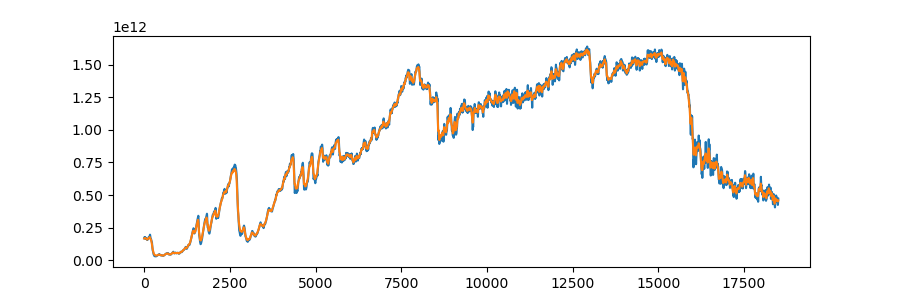

In [10]:
plt.plot(flux[1])
plt.plot(flux[0])

# Circle fit continuum

In [11]:
def get_sub_circle(x, y, r, masked=False):
    
    d = np.sqrt((x[1]-x[0])**2 + (y[1]-y[0])**2)
    x_mid = 0.5*(x[1] + x[0])
    y_mid = 0.5*(y[1] + y[0])
    biss = np.sqrt(r**2 - (d/2)**2)
    x0 = x_mid - biss*(y[1]-y[0])/d
    y0 = y_mid + biss*(x[1]-x[0])/d
    
    return lambda x:f_circle(x, r, [x0,y0], masked=masked)

def f_circle(x, r, center=[0,0], masked=False):
    
    x0, y0 = center
    sq_arg = r**2-(x-x0)**2
    idx_valid = (sq_arg >= 0)
    out = np.ones(x.shape) * np.nan
    out[idx_valid] = np.sqrt(sq_arg[idx_valid])
    out = y0 - out
    if masked:
        return np.ma.masked_invalid(out)
    else:
        return out

In [12]:
class BadCircleError(ValueError):
    
    pass

In [13]:
class CircleContinuum():
    
    def __init__(self, r_x, r_y=None):
        
        self.r = r_x
        if r_y is None:
            self.r_y = r_x
        else:
            self.r_y = r_y            
    
    def get_cont(self, x, y):
        
        # rescale y
        y_min = 0
        scale = self.r_y / self.r
        y = (y - y_min) / scale

        i=0
        cont = np.ones(len(y)) * np.nan
        while i < len(y)-1:
            try:
                circle, j = self.get_good_circle(x[i:], y[i:])
                cont[i:i+j+1] = circle(x[i:i+j+1])
#                 plt.plot(x[i:i+j+1], circle(x[i:i+j+1]))
                i += j
            except BadCircleError as e:
#                 print('skip', i)
                i += 1
            
#         # Eventually add a pad?
#         sides = np.median(cont)
#         y_pad = np.pad(y, 1, 'constant', constant_values=sides)
            
        return cont * scale
    
    def get_good_circle(self, x, y, r=None, debug=False, epsilon=1e-8):
        
        if r is None:
            r = self.r

        for i in range(1, len(x)):
            circle = get_sub_circle(x[[0,i]], y[[0,i]], r)
            
            bad_circle = (circle(x) - y)
            norm = np.clip(np.abs(y), epsilon, None)
            idx = np.isfinite(bad_circle)
            bad_circle = ((bad_circle / norm)[idx] < -epsilon)
            
            if not bad_circle.any():
                break

            if debug: print(i, (circle(x) - y), (circle(x) < y))
        else:
            raise BadCircleError("No good circle")

        return circle, i

In [14]:
np.diff(flux[1]).max() * 5

83546514702.9773

In [15]:
# test = CircleContinuum(10, r_y=5)
test = CircleContinuum(3e-2, r_y=10*83546514702)

In [16]:
# plt.plot(np.arange(10), y_rand*10/5,"--")
# cont = test.get_cont(np.arange(10), y_rand)
cont = test.get_cont(wv_overlap[:10000], flux[1][:10000])


<IPython.core.display.Javascript object>


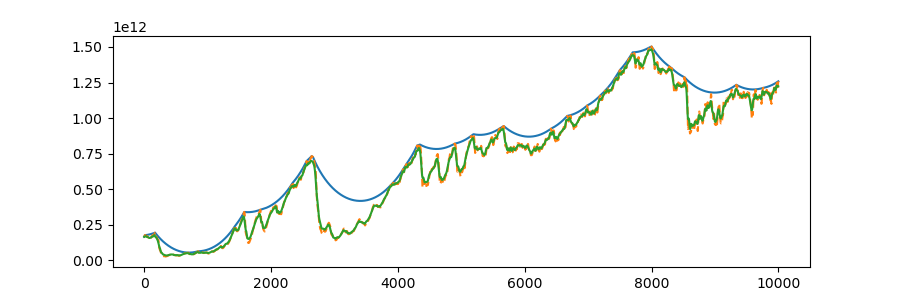

In [17]:
plt.plot(cont)
# plt.plot(y_rand)
plt.plot(flux[1][:10000],"--")
plt.plot(flux[0][:10000])

### Fit low frequency features (pseudo continuum)

<IPython.core.display.Javascript object>


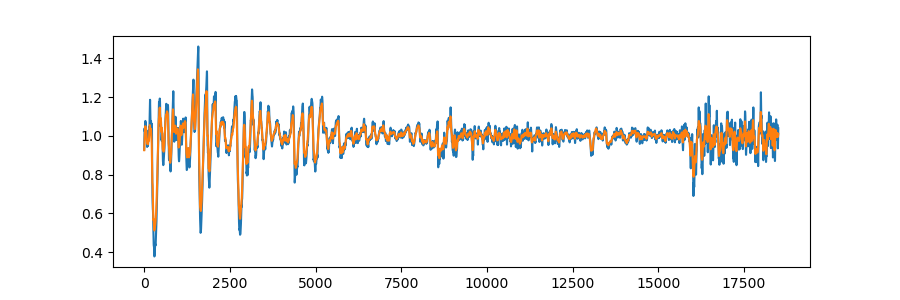

In [18]:
window_len = 200
std = np.ones_like(flux[0])
for i_wndw in range(len(flux[0])-2*window_len):
    std_wndw = np.std(flux[0][i_wndw:i_wndw + window_len])
    std[i_wndw + window_len] = std_wndw
    
std[:window_len] = std[window_len]
std[-window_len:] = std[-window_len-1]

pseudo_cont = UnivariateSpline(wv_overlap, flux[0], w=1/std, s=len(flux[0]))

plt.plot(flux[1]/pseudo_cont(wv_overlap))
plt.plot(flux[0]/pseudo_cont(wv_overlap))

### Estimate kernel by hand

In [19]:
from extract.convolution import gaussians

In [20]:
gauss_ker = gaussians(np.arange(201), 100, 10)

<IPython.core.display.Javascript object>


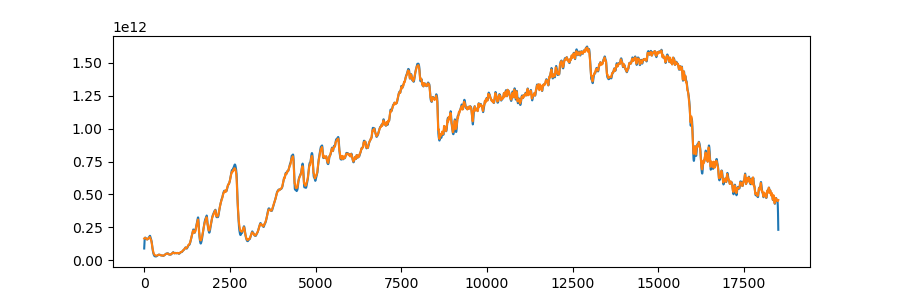

In [21]:
plt.plot(np.convolve(flux[1], gauss_ker, mode='same'))
plt.plot(flux[0])

### Lucy Richardson

In [22]:
from scipy.integrate import quad
from scipy.optimize import root_scalar

In [23]:
from astropy.convolution import convolve

In [24]:
def richardson_lucy_inv(x_conv, x_deconv, guess=None, iterations=50, pad=30, ker_pad=30, ax=None, filter_epsilon=None):

    indices_plt = np.arange(len(x_deconv))
    idx_pad = slice(pad, -pad)
    idx_ker_pad = slice(ker_pad, -ker_pad)
    
    if guess is None:
        guess = np.full(x_conv.shape, 0.5, dtype=float)
        guess /= guess.sum()
    
    kernel = guess.copy()
#     kernel /= kernel.sum()
    
    x_conv = x_conv[idx_pad]
    kernel = kernel[idx_ker_pad]
    
    if ax is not None:
        ax[0].plot(indices_plt, x_deconv, "r")
        ax[0].plot(indices_plt[idx_pad], x_conv, "g")
    
    x_deconv = x_deconv.copy()
#     x_deconv /= np.nansum(x_deconv)
        
    x_deconv_mirror = np.flip(x_deconv)

    for _ in range(iterations):
        conv = np.convolve(x_deconv, kernel, mode='same')[idx_pad]
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, x_conv / conv)
        else:
            relative_blur = x_conv / conv
        if ax is not None:
            conv = np.convolve(x_deconv, kernel/kernel.sum(), mode='same')[idx_pad]
            ax[0].plot(indices_plt[idx_pad], conv, "k", alpha=0.1, zorder=0)
            ax[1].semilogy(indices_plt[idx_pad], relative_blur, "k", alpha=0.1)

#         relative_blur /= relative_blur.sum()
        kernel *= np.convolve(x_deconv_mirror, relative_blur, mode='same')[idx_ker_pad]
#         kernel /= kernel.sum()
        
#         kernel /= np.nansum(kernel)
        if ax is not None:
            ax[2].plot(indices_plt[idx_ker_pad], kernel, "k", alpha=0.1)

    out = np.zeros_like(guess)
    out[idx_ker_pad] = kernel
    return out

In [25]:
from extract.convolution import get_c_matrix

In [26]:
from scipy.interpolate import interp1d

In [27]:
def convolve_on_grid(grid, y_grid, kernel, **kwargs):
    
    c_matrix = get_c_matrix(kernel, grid, **kwargs)
    
    out = c_matrix.dot(y_grid)
    
    return out

def _correct_kernel(grid, kernel, correction, c_kwargs, bounds_error=False, fill_value=0, kind='cubic'):
    
    c_kwargs = c_kwargs.copy()
    
    n_grid = len(grid)
    # To get the kernel at the center of the grid
    i_bounds = [int(np.floor(n_grid/2)),
                -int(np.ceil(n_grid/2-1))]
    c_kwargs['i_bounds'] = i_bounds
    ker_proj = get_c_matrix(kernel, grid, **c_kwargs)
    ker_proj = ker_proj.toarray().squeeze()
    
    ker_proj = ker_proj * correction
    
    kwargs = {'bounds_error': bounds_error,
              'fill_value': fill_value,
              'kind': kind}
    ker_centered = interp1d(grid - grid[i_bounds[0]], ker_proj, **kwargs)
    
    def new_kernel(x, x0):
        return ker_centered(x - x0)
    
    return new_kernel

def find_kernel_on_grid(grid, y_deconv, y_conv, pad_idx=None, pad=None, ker_guess=None,
                        iterations=50, filter_epsilon=None, ax=None, c_kwargs=None, **kwargs):
    
    if ker_guess is None:
        def kernel(x, x0):
            mean_d_grid = np.mean(np.diff(grid))
            return gaussians(x, x0, 10*mean_d_grid)
    else:
        kernel = ker_guess
    
    
    if pad_idx != 0:
        i_bounds = [pad_idx, -pad_idx]
        if y_conv.size == y_deconv.size:
            y_conv = y_conv[slice(*i_bounds)]

        grid_conv = grid[slice(*i_bounds)]
        grid_corr = grid_conv[slice(*i_bounds)]
    else:
        i_bounds = None
        grid_conv = grid
        grid_corr = grid_conv
        
    if c_kwargs is None:
        c_kwargs = {}
        
    y_deconv_flip = np.flip(y_deconv)
    grid_flip = np.flip(-grid)
    
    if ax is not None:
        ax[0].plot(grid, y_deconv)
        ax[0].plot(grid_conv, y_conv)

    for _ in range(iterations):
        conv = convolve_on_grid(grid, y_deconv, kernel,i_bounds=i_bounds, **c_kwargs)
        if ax is not None:
            ax[0].plot(grid_conv, conv, "k", alpha=0.1, zorder=0)
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, y_conv / conv)
        else:
            relative_blur = y_conv / conv
            
        def blur_ker(x, x0):
            grid_centered = grid_conv - grid_conv.mean()
            fct_interp = interp1d(grid_centered, relative_blur,
                                  kind='cubic', bounds_error=None, fill_value=0)

            return fct_interp(x - x0)

        correction = convolve_on_grid(grid_flip, y_deconv_flip, blur_ker, i_bounds=i_bounds,**c_kwargs)
        kernel = _correct_kernel(grid_conv, kernel, correction, c_kwargs, **kwargs)
        
        if ax is not None:
            ax[1].plot(grid_conv, relative_blur,"k", alpha=0.1)
            ax[2].plot(grid, kernel(grid, grid.mean()),"k", alpha=0.1)

    return kernel

def richardson_lucy_grid(grid, y_conv, kernel, pad_idx=None, pad=None, guess=None,
                        iterations=50, filter_epsilon=None, ax=None, c_kwargs=None, **kwargs):

    if guess is None:
        guess = np.full(grid.shape, 0.5, dtype=float)
        
    if pad_idx is None:
        pad_idx = 0
    
    y_deconv = guess.copy()    
    
    if pad_idx != 0:
        i_bounds = [pad_idx, -pad_idx]
        if y_conv.size == y_deconv.size:
            y_conv = y_conv[slice(*i_bounds)]

        grid_conv = grid[slice(*i_bounds)]
        idx_corr = slice(2*pad_idx, -2*pad_idx)
    else:
        i_bounds = None
        grid_conv = grid
        idx_corr = slice(None)
        
    if c_kwargs is None:
        c_kwargs = {}

    
#     if ax is not None:
#         ax[0].plot(grid, y_deconv)
#         ax[0].plot(grid_conv, y_conv)

    for _ in range(iterations):
        conv = convolve_on_grid(grid, y_deconv, kernel, i_bounds=i_bounds, **c_kwargs)
#         if ax is not None:
#             ax[0].plot(grid_conv, conv, "k", alpha=0.1, zorder=0)
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, y_conv / conv)
        else:
            relative_blur = y_conv / conv
            
        def ker_mirror(x, x0):
            # Flip kernel function
            return kernel(-x, -x0)

        correction = convolve_on_grid(grid_conv, relative_blur, ker_mirror, i_bounds=i_bounds,**c_kwargs)
        y_deconv[idx_corr] *= correction
        
#         if ax is not None:
#             ax[1].plot(grid_conv, relative_blur,"k", alpha=0.1)
#             ax[2].plot(grid, kernel(grid, grid.mean()),"k", alpha=0.1)

    return y_deconv

In [28]:
def richardson_lucy_classic(x, psf, guess=None, iterations=50, filter_epsilon=None, ax=None):

    if guess is None:
        guess = np.full(x.shape, 0.5, dtype=float)
    
    im_deconv = guess.copy()
        
    psf_mirror = np.flip(psf)
    
    if ax is not None:
        ax[0].plot(psf)
        ax[0].plot(x)

    for _ in range(iterations):
        conv = np.convolve(psf, im_deconv, mode='same')
        if ax is not None:
            ax[0].plot(np.convolve(psf, im_deconv/im_deconv.sum(), mode='same'),"k", alpha=0.1, zorder=0)
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, x / conv)
        else:
            relative_blur = x / conv
        im_deconv *= np.convolve(psf_mirror, relative_blur, mode='same')
        if ax is not None:
            ax[1].semilogy(relative_blur,"k", alpha=0.1)
            ax[2].plot(im_deconv,"k", alpha=0.1)

    return im_deconv

In [207]:
np.arange(11)[(11-3)//2:(3-11)//2]

array([4, 5, 6])

In [215]:
np.ones(10) # * np.arange(10) / np.sum(np.arange(10))).sum()

10.0

In [222]:
def is_odd(x_int):
    return (x_int % 2) == 1

def is_even(x_int):
    return (x_int % 2) != 1
    

def richardson_lucy_inv(y_conv, y_deconv, guess=None, length=None, weights=None, envelope=None,
                        iterations=50, filter_epsilon=None, ax=None, min_chi2=False, mode='valid'):

    if is_even(y_conv.shape[0]):
        raise ValueError('y_conv.shape[0] need to be odd.')
    if is_even(y_deconv.shape[0]):
        raise ValueError('y_deconv.shape[0] need to be odd.')
    
    if guess is None:
        if length is None:
            length = len(y_deconv) // 5
        if is_even(length):  # length needs to be odd
            length += 1
            print(length)
        guess = np.full(length, 0.5, dtype=float)
    else:
        length = len(guess)
        
    if weights is None:
        weights = np.ones_like(y_conv)
        
    if envelope is None:
        envelope = np.ones_like(guess)
        
    y_deconv_save = y_deconv
#     y_deconv = y_deconv/y_deconv.sum()
    
    psf = guess.copy()
        
    deconv_mirror = np.flip(y_deconv)
    
    if mode == 'valid':
        idx_valid = slice(length // 2, -(length//2))
        idx_corr = slice(None)
    elif mode == 'same':
        idx_valid = slice(None)
        pad = (y_conv.shape[0]-length)//2
        idx_corr = slice(pad, -pad)
    else:
        raise ValueError(f'mode = {mode} is not valid')
    y_conv = y_conv[idx_valid]
    weights = weights[idx_valid]
    
    x_deconv = np.arange(len(y_deconv))
    x_conv = x_deconv[idx_valid]
    x_psf = np.arange(len(psf))
    x_psf = x_psf - np.mean(x_psf)
    
    if ax is not None:
        ax[0].plot(x_deconv, y_deconv)
        ax[0].plot(x_conv, y_conv)

    chi2_list = []
    last_chi2 = np.inf
    for _ in range(iterations):
        conv = np.convolve(y_deconv, psf, mode=mode)
        if ax is not None:
            conv_norm = np.convolve(y_deconv_save, psf/psf.sum(), mode=mode)
            ax[0].plot(x_conv, conv_norm, "k", alpha=0.1)
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, y_conv / conv)
        else:
            relative_blur = y_conv / conv
            
        correction = np.convolve(deconv_mirror, relative_blur, mode=mode)[idx_corr]
        if min_chi2 or ax is not None:
            psf_norm = psf * correction
            psf_norm = psf_norm / psf.sum()
            conv_norm = np.convolve(y_deconv_save, psf_norm, mode=mode)
            chi2 = (conv_norm - y_conv) * weights
            chi2 = np.mean(0.5 * chi2**2)
            if (chi2 >= last_chi2) and min_chi2:
                out = (psf, True, last_chi2)
                break
            last_chi2 = chi2
            chi2_list.append(chi2)

        psf *= correction
        norm = psf.sum()
        psf *= envelope * norm   # Force the envelope on the psf
        if ax is not None:
            ax[1].semilogy(x_conv, relative_blur,"k", alpha=0.1)
            ax[2].plot(x_psf, psf/psf.sum(),"k", alpha=0.1)
    else:
        if min_chi2:
            out = (psf, False, last_chi2)
        else:
            out = psf
            
    if ax is not None:
        ax[3].semilogy(np.arange(len(chi2_list)), chi2_list, ".:")

    return out

In [33]:
test_flux_in = (np.random.rand(len(flux[0])) > 0.9).astype(float)
test_flux_in = -test_flux_in +100 # 0.001*np.arange(len(test_flux_in))
test_flux_in = np.convolve(test_flux_in, gaussians(np.arange(101), 50, 1), mode='same')
test_flux = []
test_flux.append(np.convolve(test_flux_in, gaussians(np.arange(101), 50, 15), mode='same'))
test_flux.append(test_flux_in)

In [69]:
test_flux = []
test_flux.append(np.convolve(flux[1], gaussians(np.arange(101), 50, 15), mode='same'))
test_flux.append(flux[1])

<IPython.core.display.Javascript object>


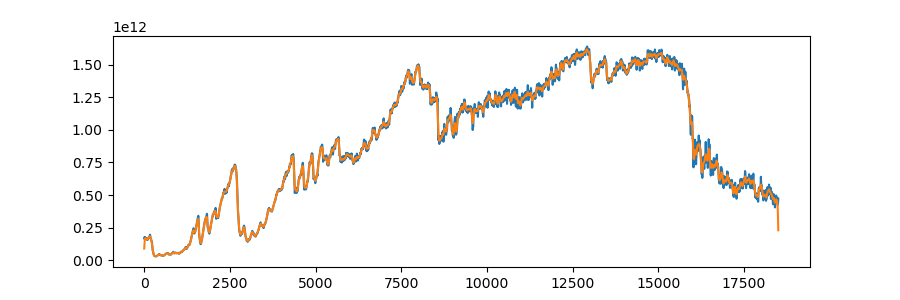

In [59]:
plt.plot(test_flux[1])
plt.plot(test_flux[0])

False
False


<IPython.core.display.Javascript object>


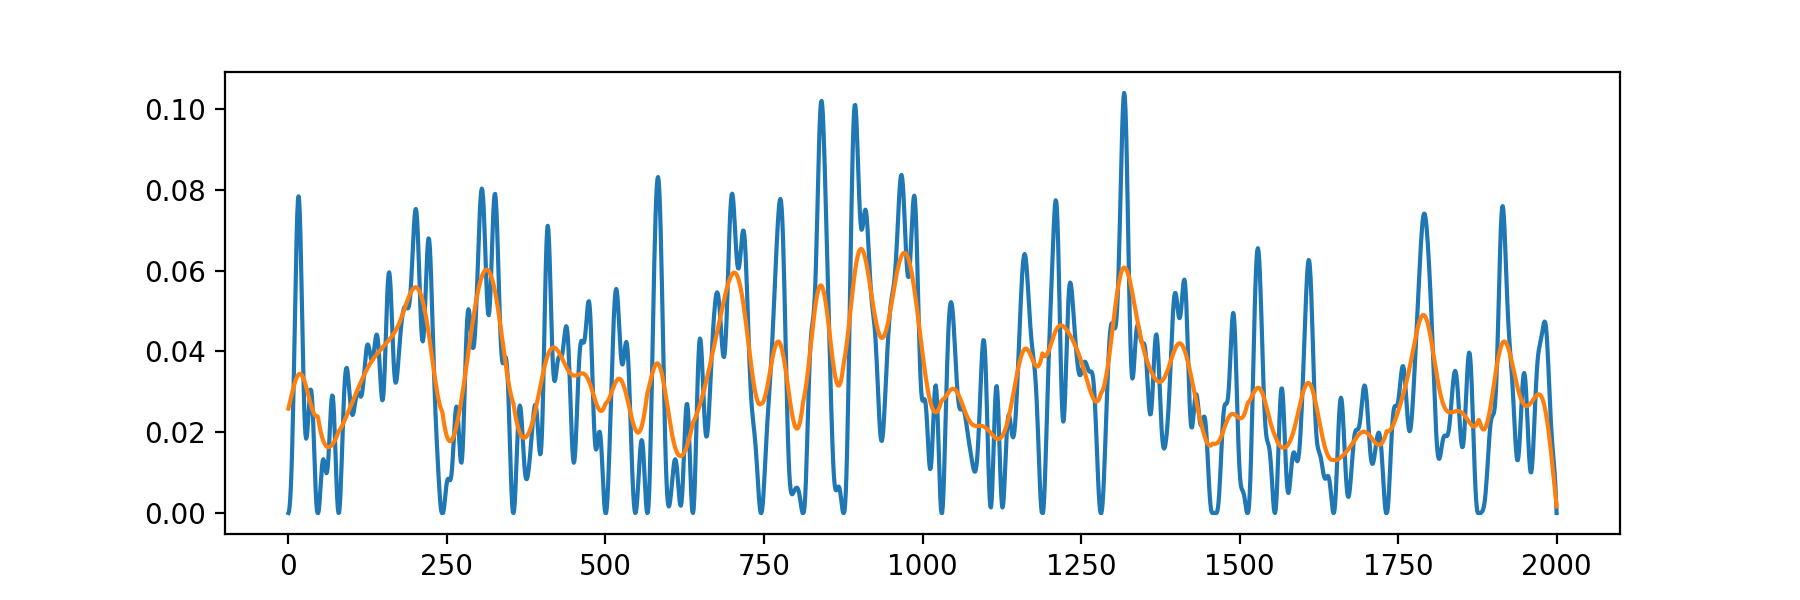

In [237]:
window = 2001

# for i_ker in range(0, 1000, 10):
i_ker = 10000
y_no_conv = test_flux[1][i_ker:i_ker+window]
y_conv = test_flux[0][i_ker:i_ker+window]
# y_no_conv = y_no_conv / pseudo_cont(wv_overlap[i_ker:i_ker+window])
# y_conv = y_conv / pseudo_cont(wv_overlap[i_ker:i_ker+window])
grid = np.arange(y_no_conv.size)

uncert = 1/np.sqrt(y_conv)


# test = CircleContinuum(3e-2, r_y=5)
test = CircleContinuum(1e-2, r_y=10*83546514702)

# plt.plot(np.arange(10), y_rand*10/5,"--")
# cont = test.get_cont(np.arange(10), y_rand)
cont = test.get_cont(wv_overlap[i_ker:i_ker+window], y_no_conv)

y_no_conv = y_no_conv / cont
y_max = y_no_conv.max()
y_no_conv = y_max - y_no_conv

# cont_conv = np.convolve(cont, gaussians(np.arange(201), 100, 15), mode='same')

y_conv = y_conv / cont
y_conv = y_max - y_conv
y_min = np.min([y_conv.min(), 0])
y_conv = y_conv - y_min

print((y_no_conv < 0).any())
print((y_conv < 0).any())
plt.plot(y_no_conv)
plt.plot(y_conv)


<IPython.core.display.Javascript object>


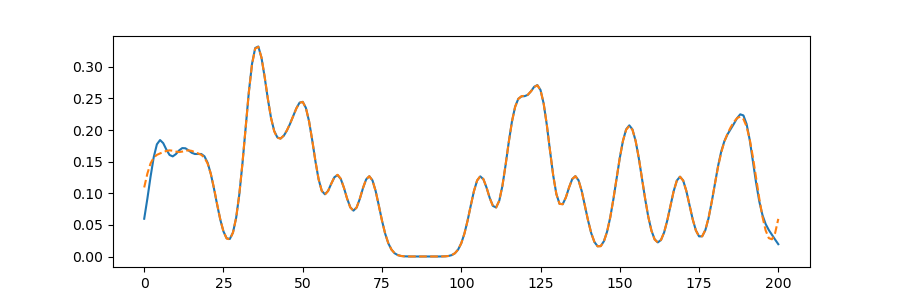

In [155]:
y_rl = richardson_lucy_classic(y_conv, gaussians(np.arange(201), 100, 3), iterations=1000)
plt.plot(np.convolve(y_rl, gaussians(np.arange(201), 100, 3), mode='same'))
plt.plot(y_conv, "--")

<IPython.core.display.Javascript object>


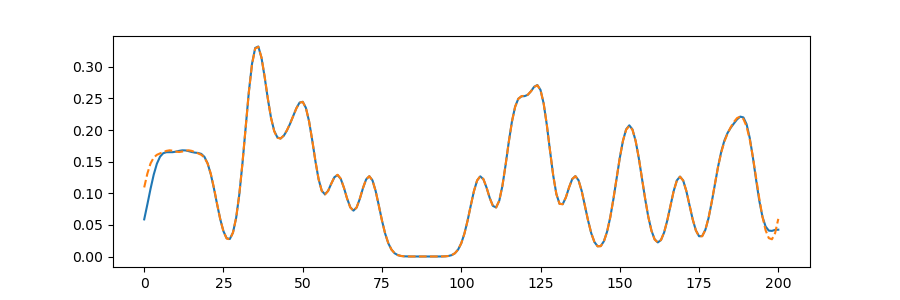

In [151]:
y_rl = richardson_lucy_grid(grid, y_conv, lambda x, x0:gaussians(x, x0, 3), iterations=1000, idx_pad=20)
plt.plot(np.convolve(y_rl, gaussians(np.arange(201), 100, 3), mode='same'))
plt.plot(y_conv, "--")

<IPython.core.display.Javascript object>


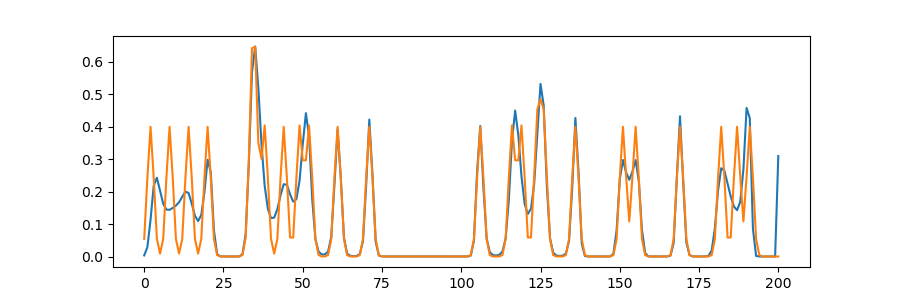

In [153]:
plt.plot(y_rl)
plt.plot(y_no_conv)

<IPython.core.display.Javascript object>


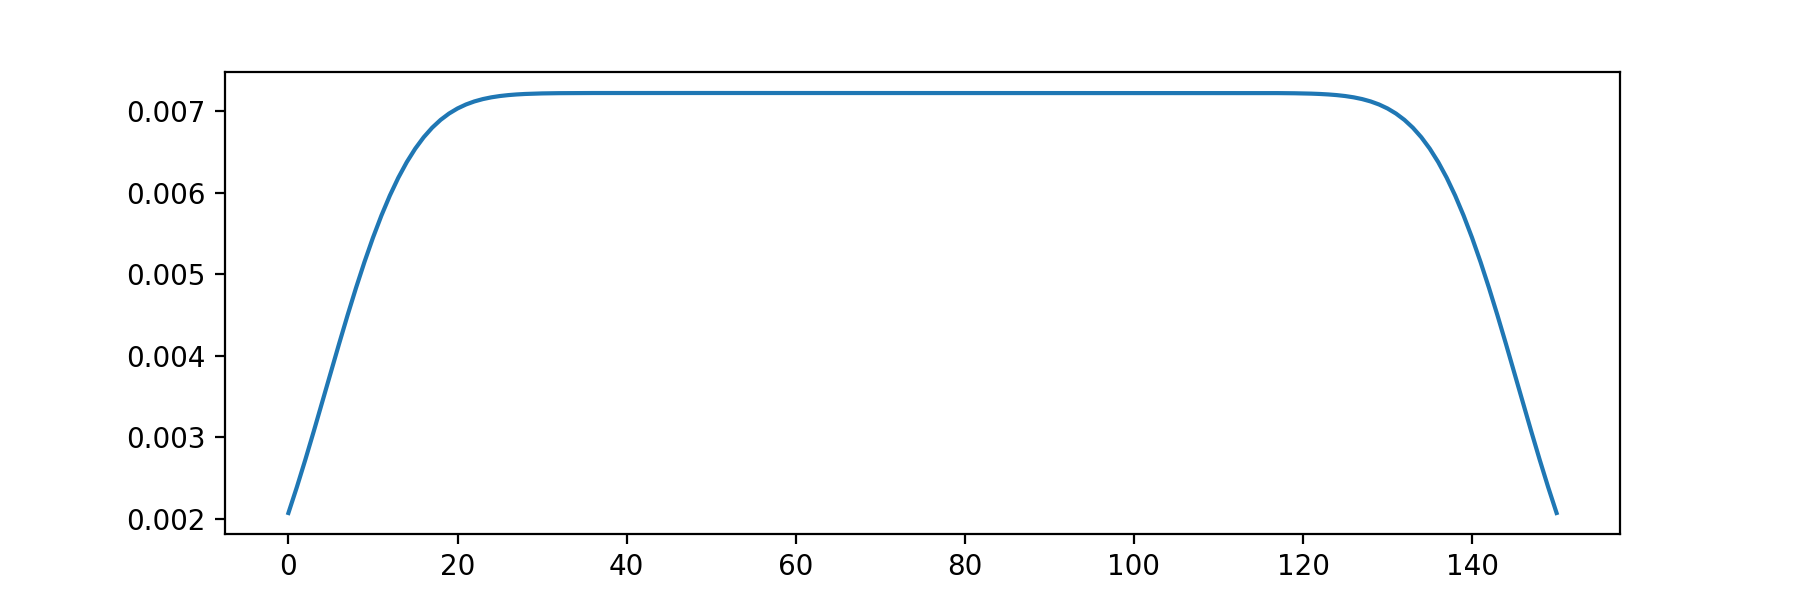

<IPython.core.display.Javascript object>


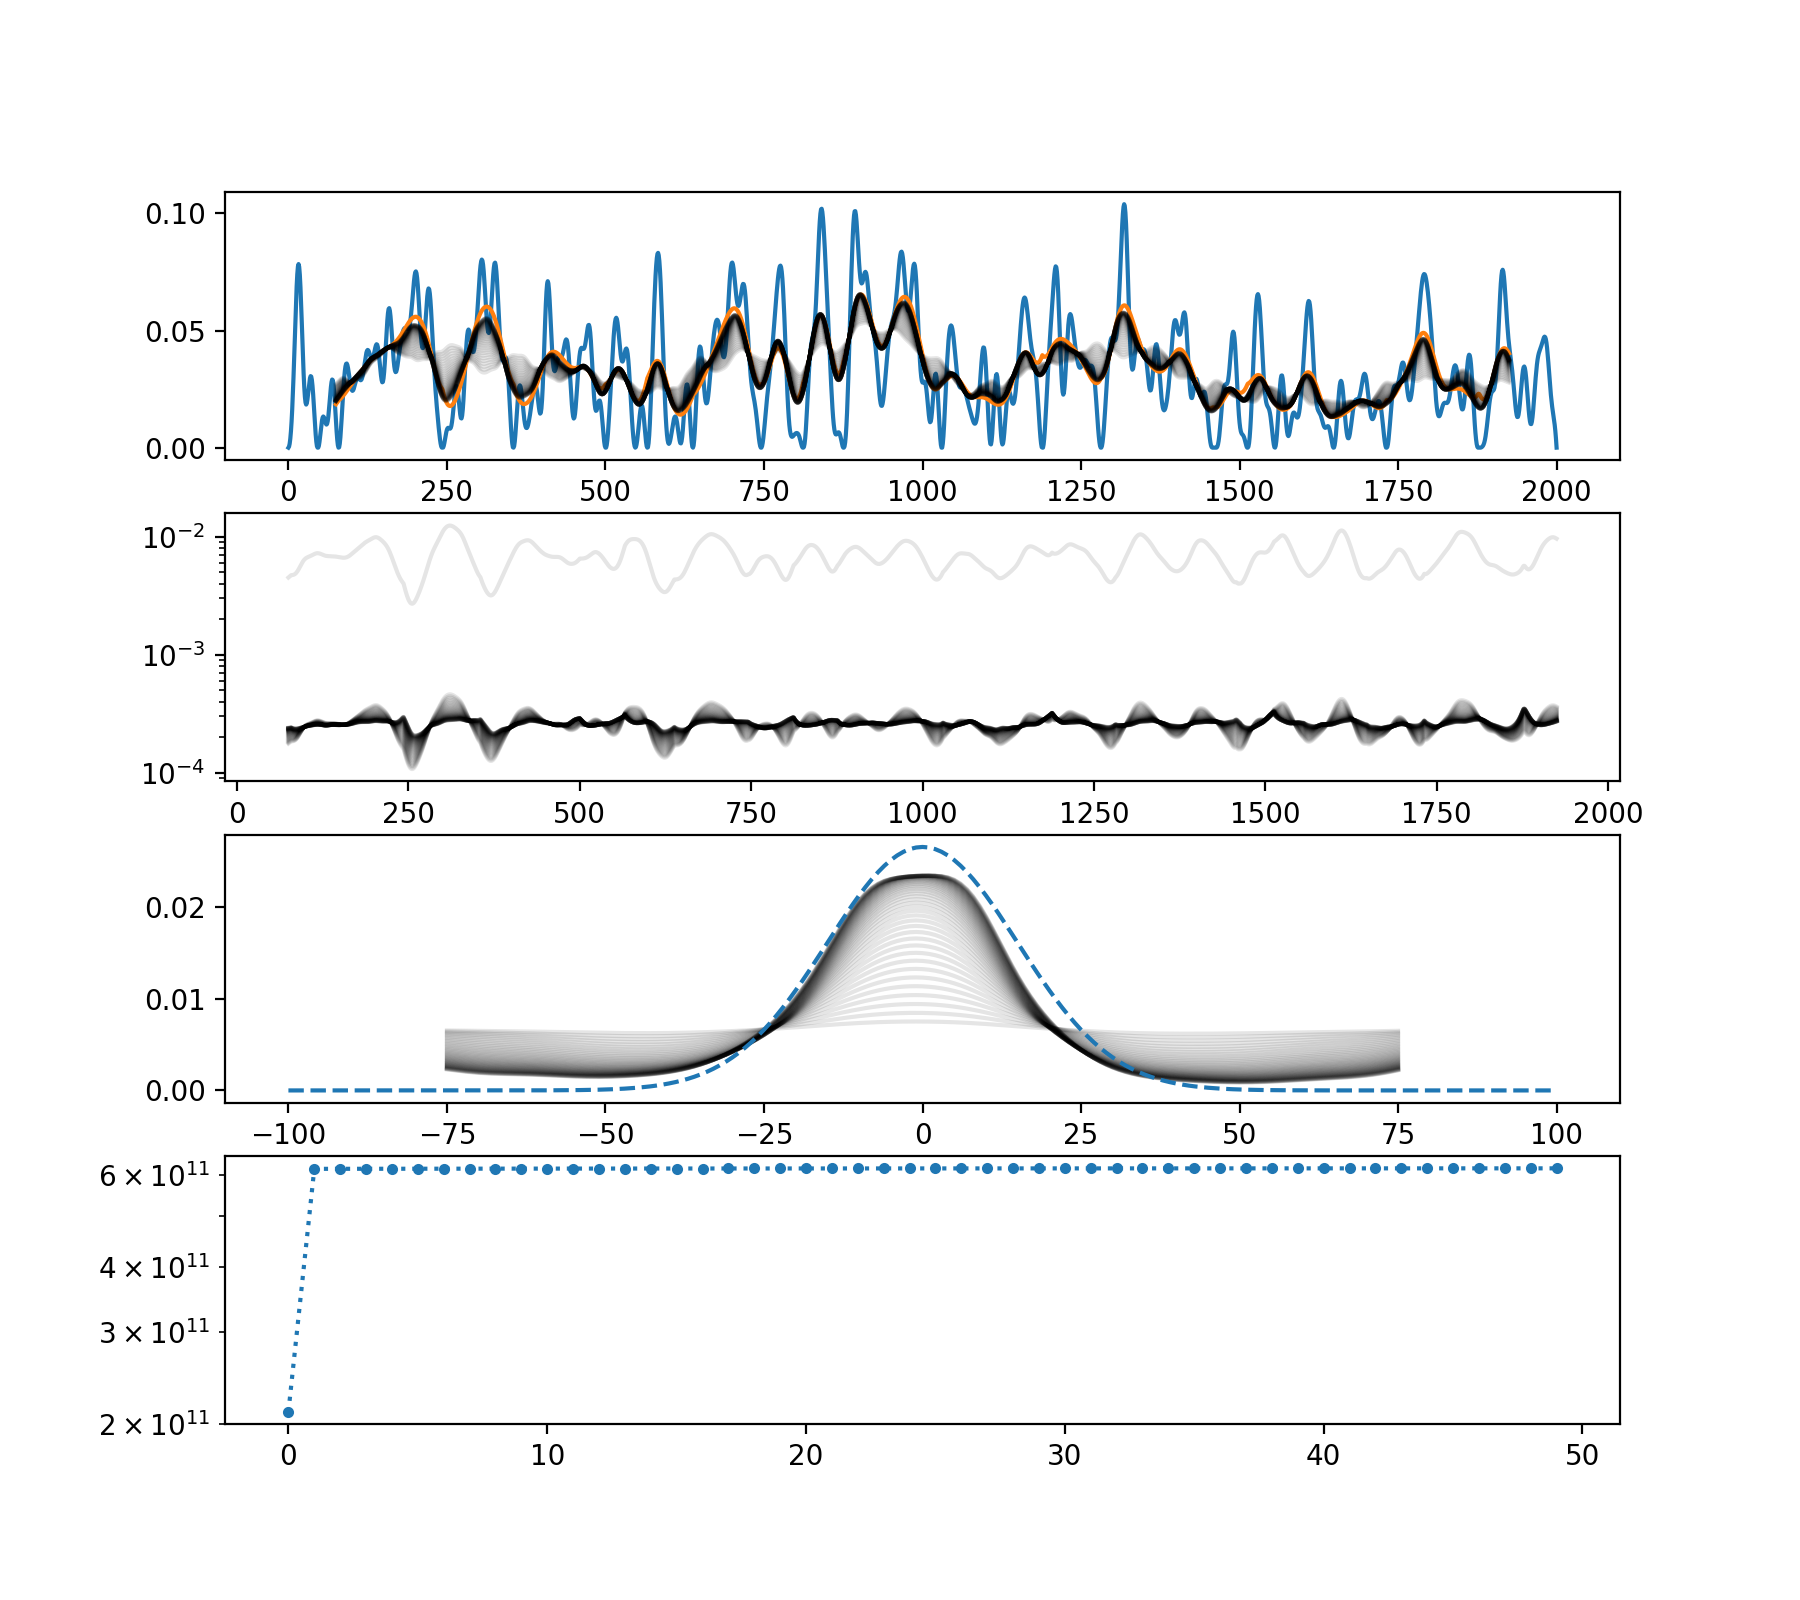

<IPython.core.display.Javascript object>


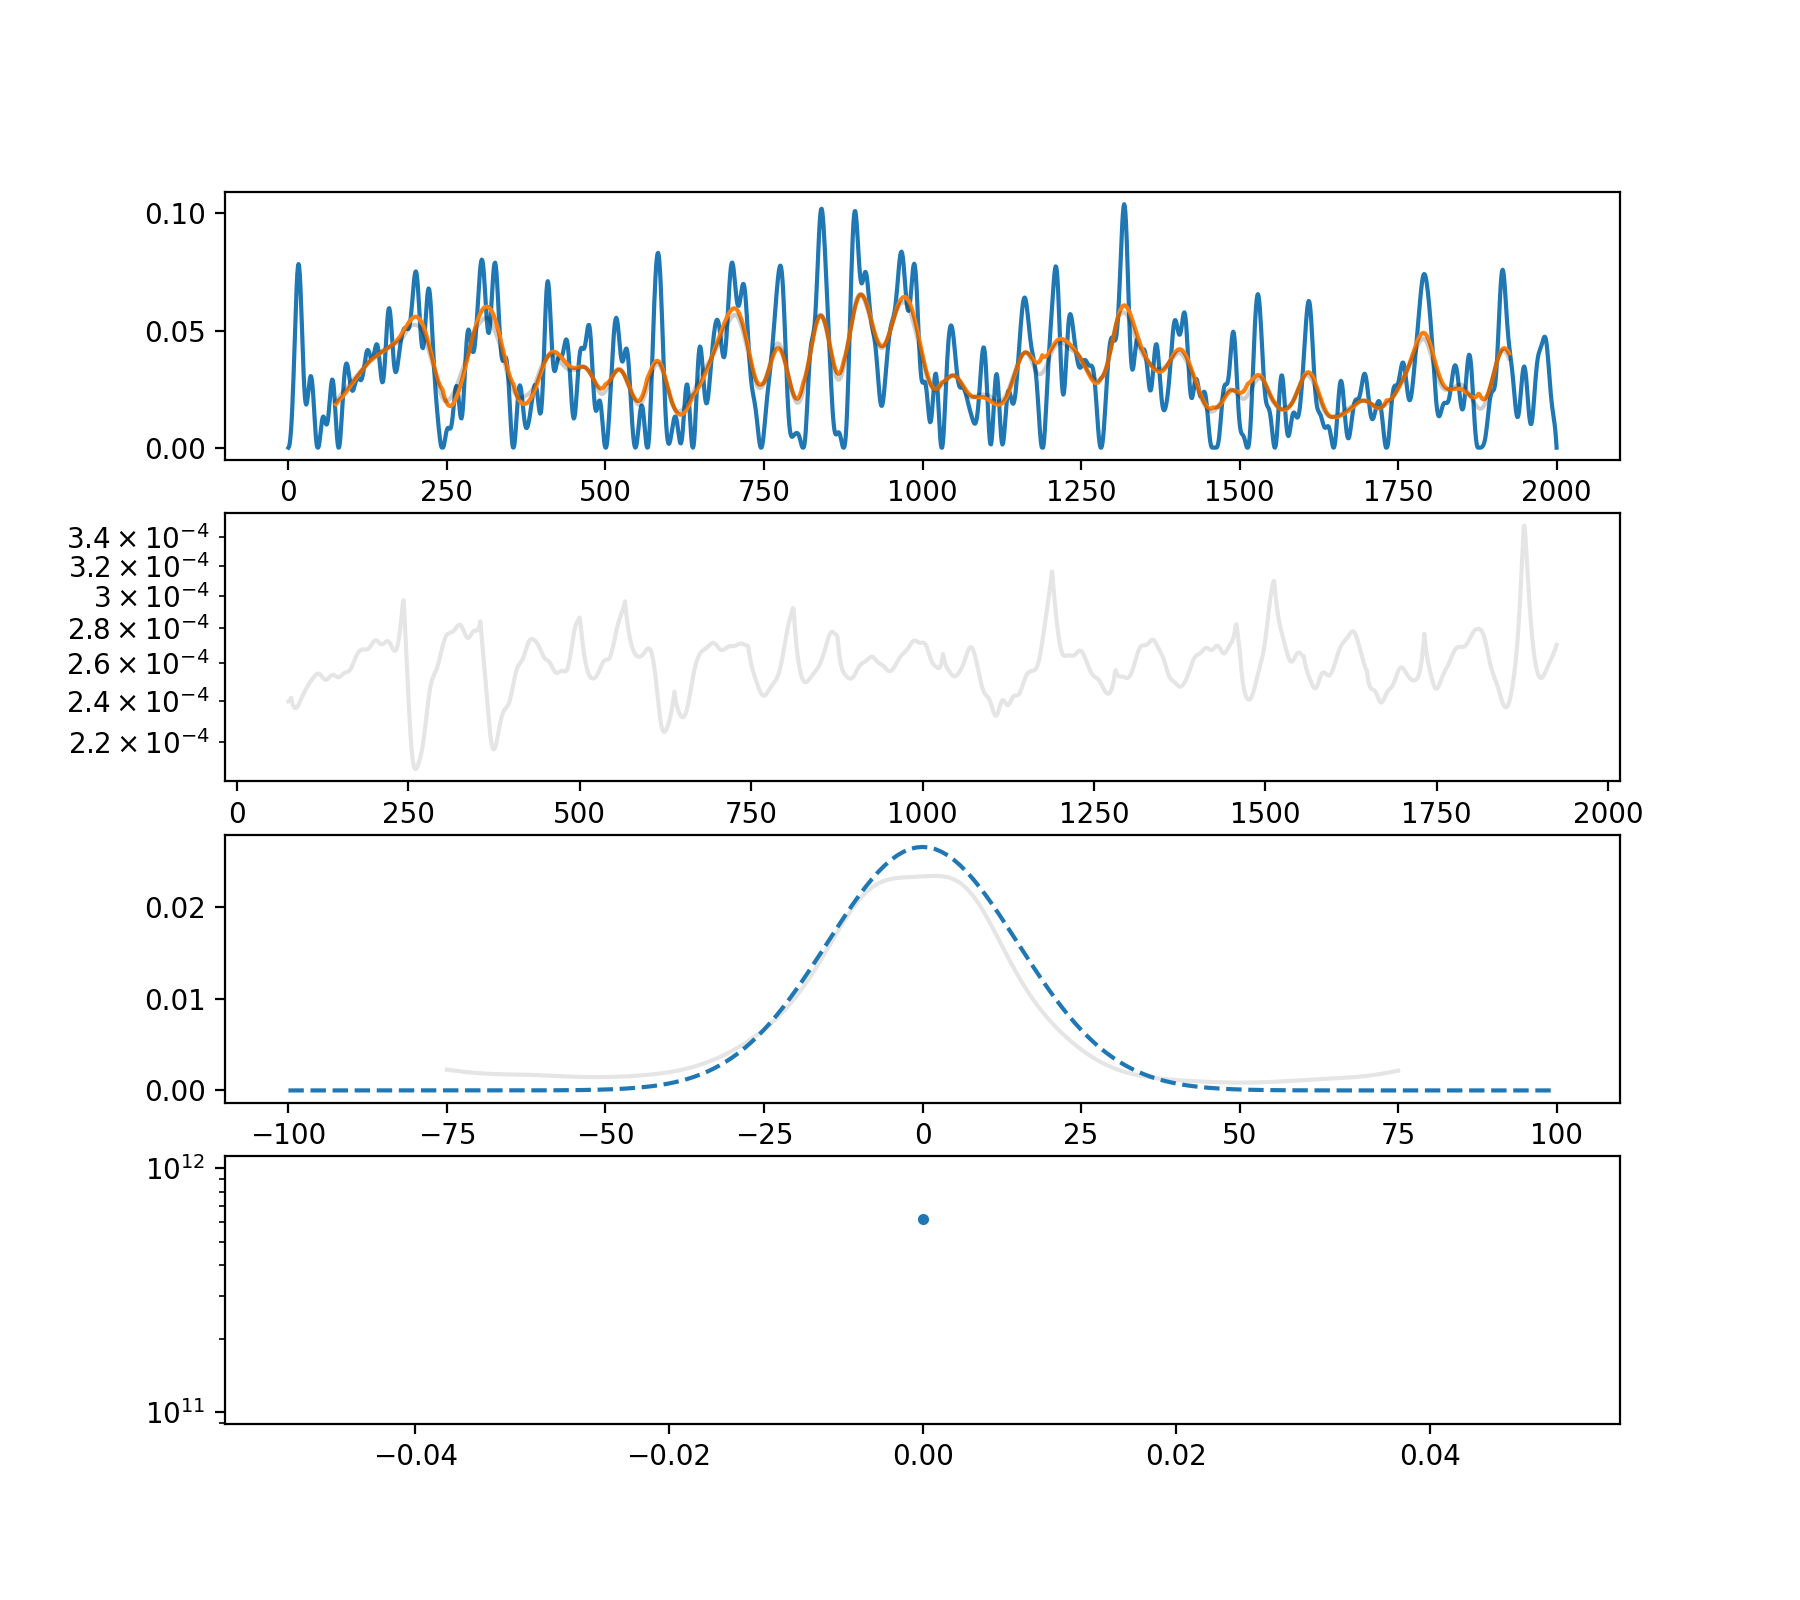

In [238]:
real_psf = gaussians(np.arange(201), 100, 15)
real_psf /= real_psf.sum()

guess = np.ones(151)
envelope = np.ones_like(guess)
envelope[:5] = 0
envelope[-5:] = 0
envelope = np.convolve(envelope, gaussians(np.arange(101), 50, 8), mode='same')
envelope /= envelope.sum()

plt.figure()
plt.plot(envelope)

weights = 1/np.clip(uncert * y_conv, 1e-8, None)

fig, ax = plt.subplots(4,1, figsize=(9, 8))
kernel = richardson_lucy_inv(y_conv, y_no_conv,guess=guess, iterations=50,
                             ax=ax, weights=weights, mode='valid')
ax[2].plot(np.arange(-100, 101), real_psf, "--")

# kernel = richardson_lucy_inv(y_conv, y_no_conv, guess=kernel[:], iterations=500)

fig, ax = plt.subplots(4,1, figsize=(9, 8))
kernel, _, _ = richardson_lucy_inv(y_conv, y_no_conv, guess=kernel, iterations=500,
                             ax=ax, min_chi2=True, weights=weights, mode='valid')

ax[2].plot(np.arange(-100, 101), real_psf, "--")

<IPython.core.display.Javascript object>


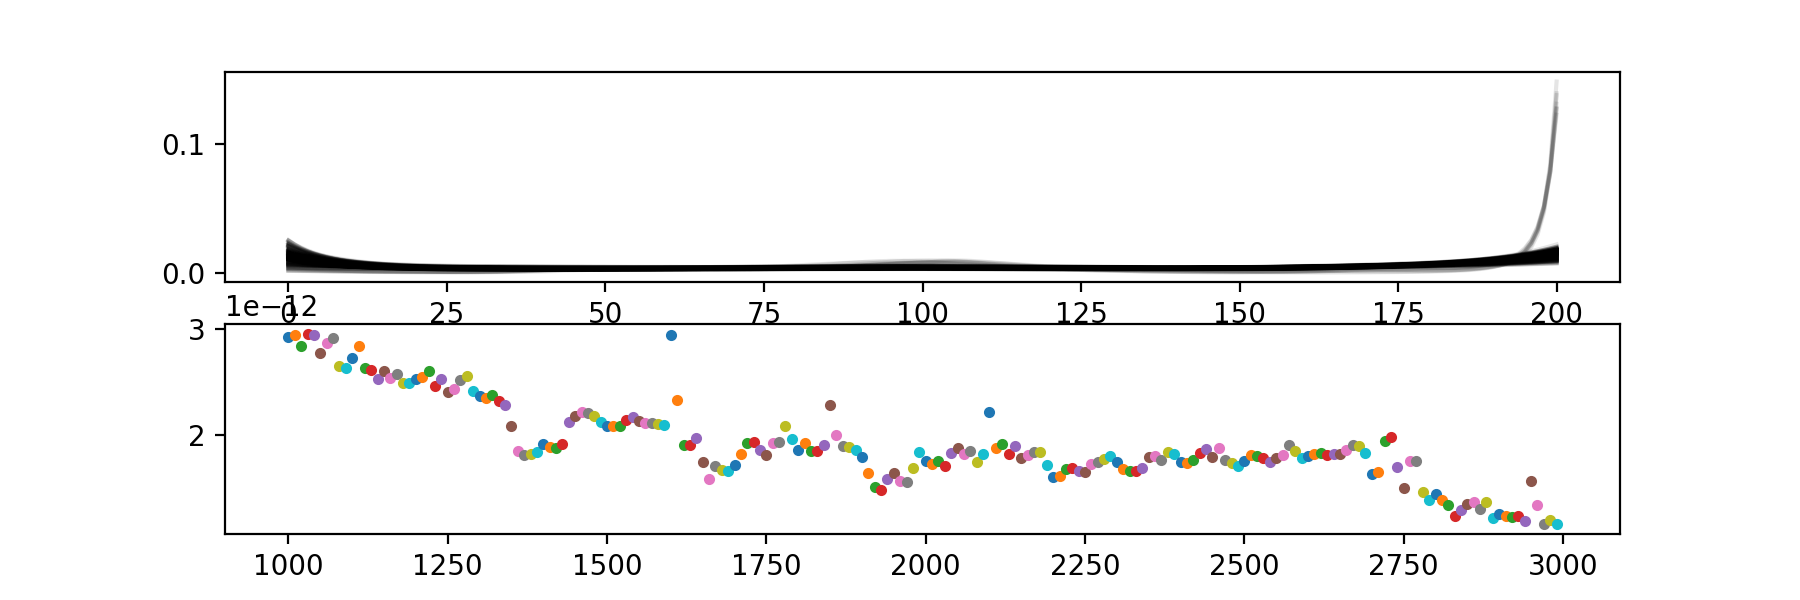

In [253]:
n_burn = 20
n_try = 300

window = 3001
ker_guess = np.ones(201, dtype=float)

envelop = np.ones(window)
envelop[:5] = 0
envelop[-5:] = 0
envelop = np.convolve(envelop, gaussians(np.arange(101), 50, 15), mode='same')
# envelop /= envelop.sum()

fig, ax = plt.subplots(2, 1)
final_ker = np.zeros_like(ker_guess)
chi2_list = []
kernel_list = []
for i_ker in range(1000, 3000, 10):
# i_ker = 10000
    y_no_conv = test_flux[1][i_ker:i_ker+window]
    y_conv = test_flux[0][i_ker:i_ker+window]

    uncert = 1/np.sqrt(y_conv)
    weights = 1/np.clip(uncert * y_conv, 1e-8, None)



    # test = CircleContinuum(3e-2, r_y=5)
    test = CircleContinuum(2e-2, r_y=10*83546514702)

    # plt.plot(np.arange(10), y_rand*10/5,"--")
    # cont = test.get_cont(np.arange(10), y_rand)
    cont = test.get_cont(wv_overlap[i_ker:i_ker+window], y_no_conv)

    y_no_conv = y_no_conv / cont
    y_max = y_no_conv.max()
    y_no_conv = y_max - y_no_conv

    cont = np.convolve(cont, gaussians(np.arange(201), 100, 15), mode='same')
    
    y_conv = y_conv / cont
    y_conv = y_max - y_conv
    y_min = np.min([y_conv.min(), 0])
    y_conv = y_conv - y_min
    
#     y_no_conv = y_no_conv * envelop
#     y_conv = y_conv * envelop

    kernel = richardson_lucy_inv(y_conv, y_no_conv,guess=ker_guess,
                                 iterations=n_burn, mode='valid')
    kernel, converged, chi2 = richardson_lucy_inv(y_conv, y_no_conv,guess=kernel, iterations=n_try,
                                 min_chi2=True, weights=weights, mode='valid')
    if converged:
        chi2_list.append(chi2)
        kernel_list.append(kernel/kernel.sum())
#         final_ker += 1/chi2 * kernel
        ax[0].plot(kernel/kernel.sum(), "k", alpha=0.1)
        ax[1].plot(i_ker, chi2, ".")


<IPython.core.display.Javascript object>


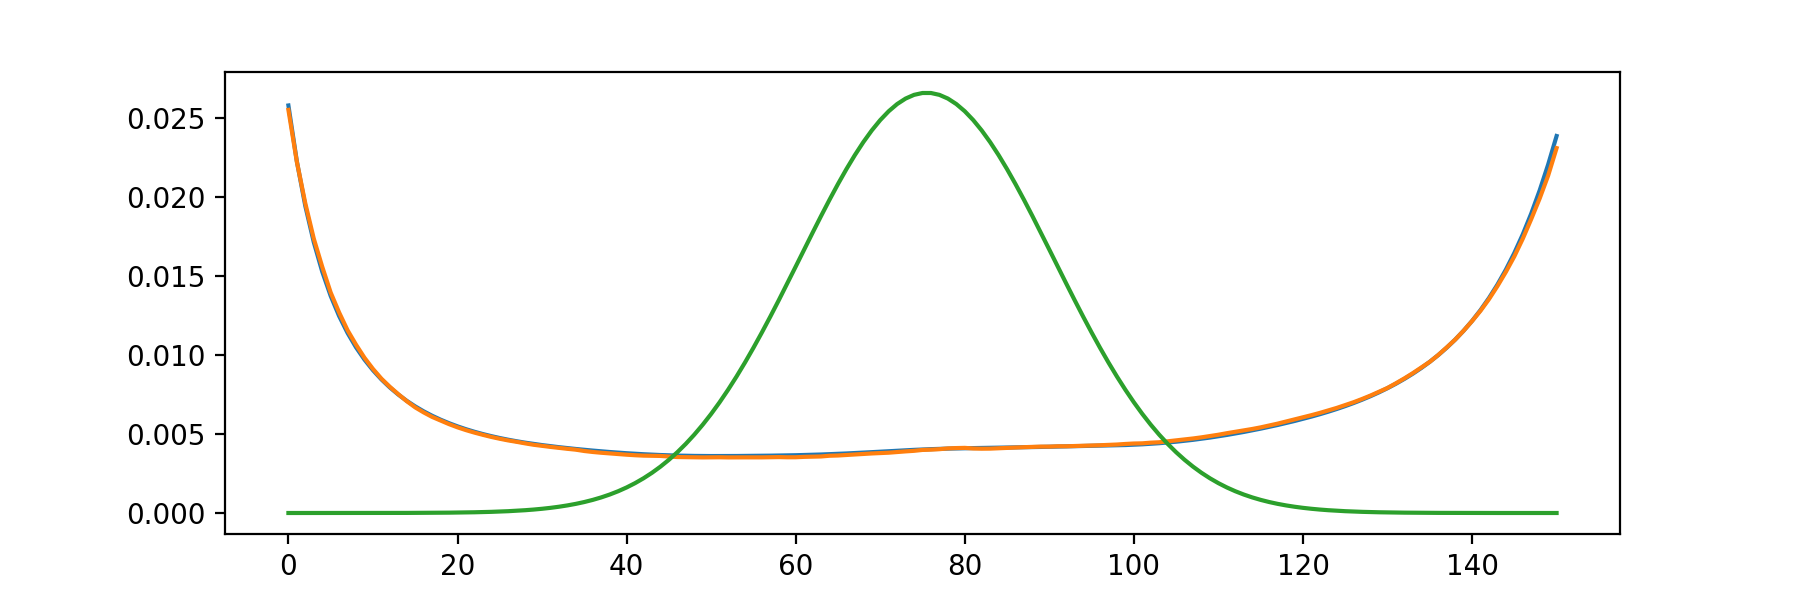

In [251]:
plt.plot(np.mean(kernel_list, axis=0))
plt.plot(np.median(kernel_list, axis=0))
plt.plot(gaussians(np.arange(151), 151/2, 15))

<IPython.core.display.Javascript object>


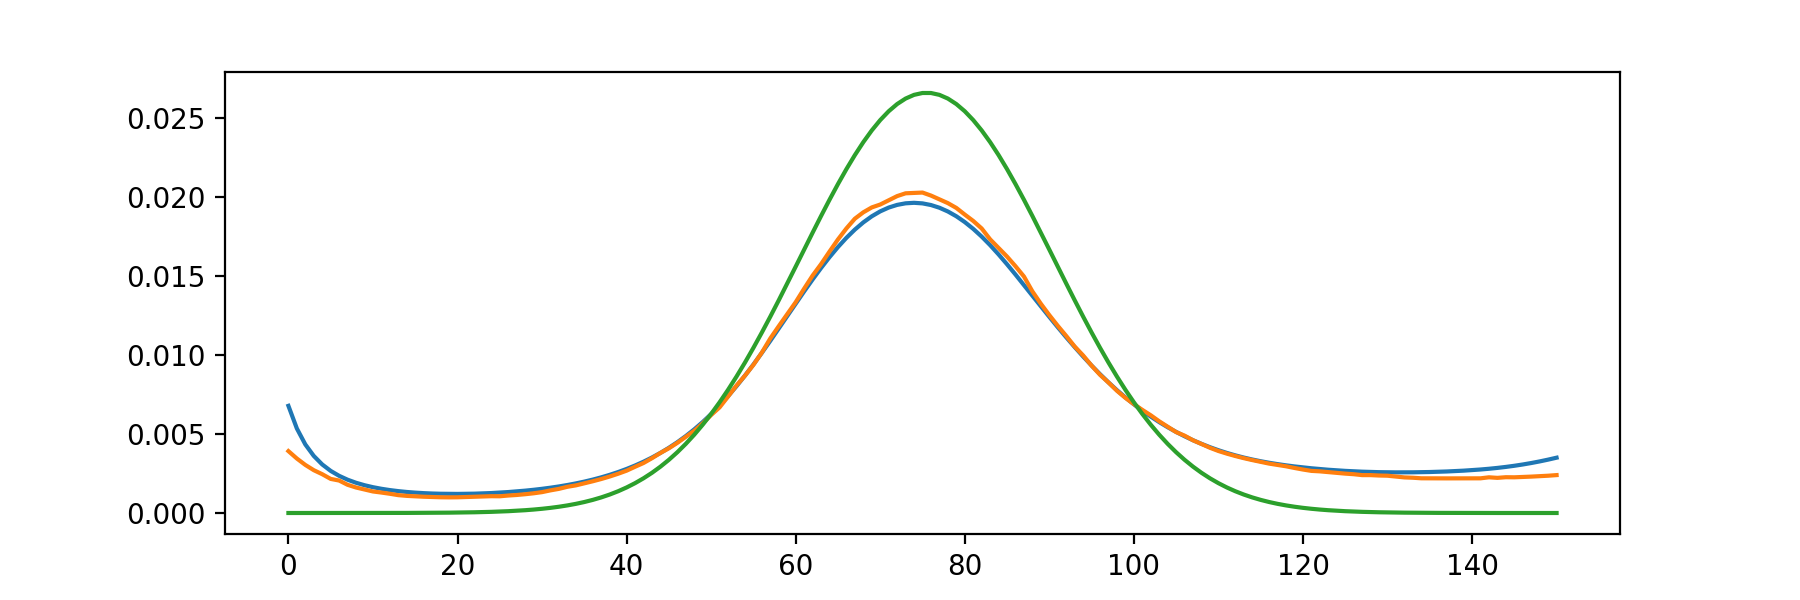

In [232]:
plt.plot(np.mean(kernel_list, axis=0))
plt.plot(np.median(kernel_list, axis=0))
plt.plot(gaussians(np.arange(151), 151/2, 15))

<IPython.core.display.Javascript object>


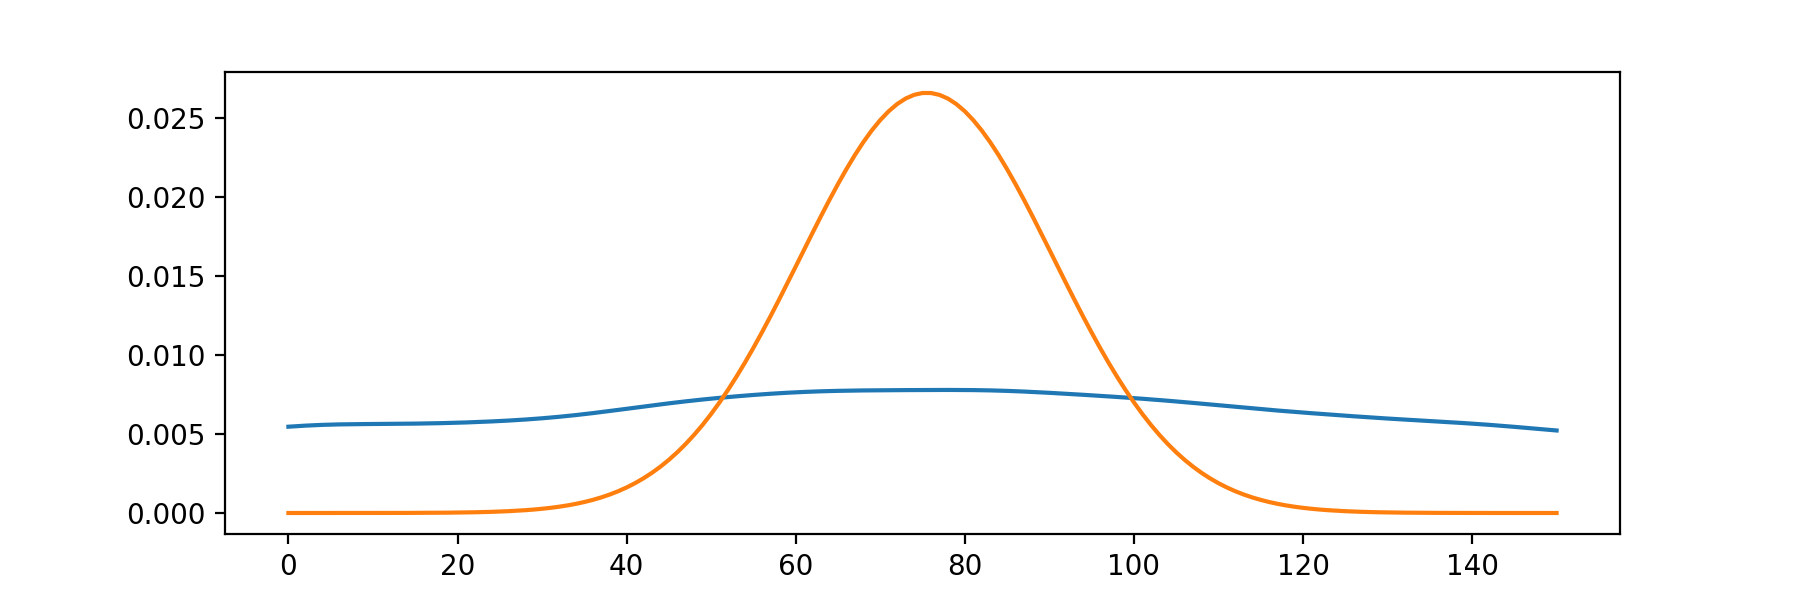

In [191]:
kernel_list = np.array(kernel_list)
kernel_list = kernel_list / kernel_list.sum(axis=1)[:, None]
weights = 1
# weights = np.array(1/np.sqrt(chi2))
# weights /= (weights).sum()
final_ker = np.sum(weights * kernel_list, axis=0)
plt.plot(final_ker/final_ker.sum())

# weights = np.array(1/chi2)
# weights /= (weights).sum()
# final_ker = np.sum(weights * kernel_list, axis=0)
# plt.plot(final_ker/final_ker.sum())

# weights = np.array(chi2)
# weights /= (weights).sum()
# final_ker = np.sum(weights * kernel_list, axis=0)
# plt.plot(final_ker/final_ker.sum())

plt.plot(gaussians(np.arange(151), 151/2, 15))

<IPython.core.display.Javascript object>


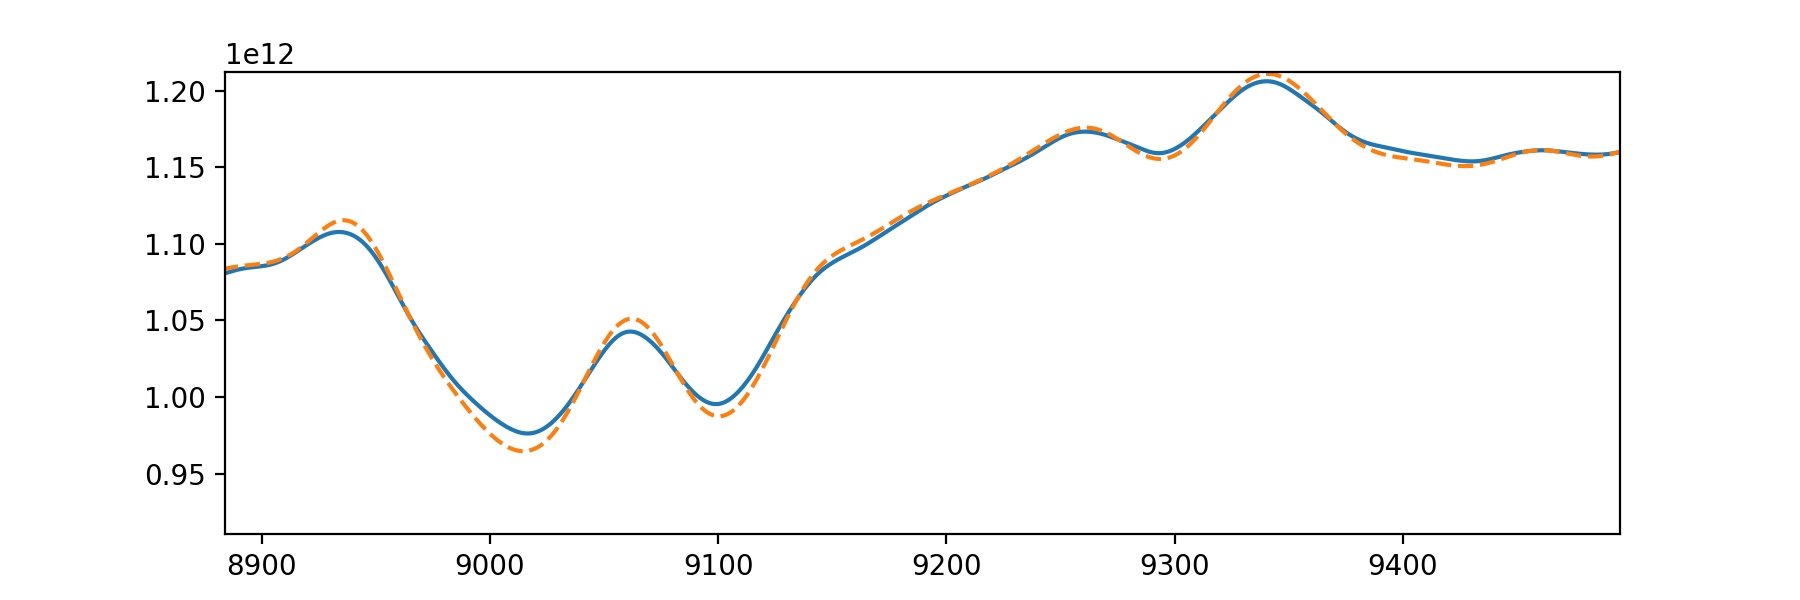

In [153]:
plt.plot(np.convolve(test_flux[1], final_ker/final_ker.sum(), mode='same'))
plt.plot(test_flux[0], "--")

<IPython.core.display.Javascript object>


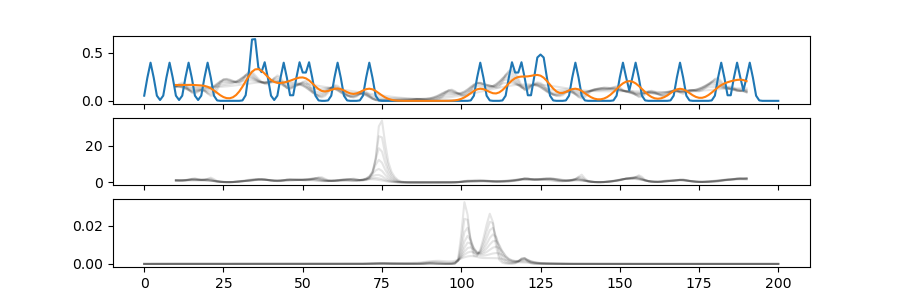

<IPython.core.display.Javascript object>


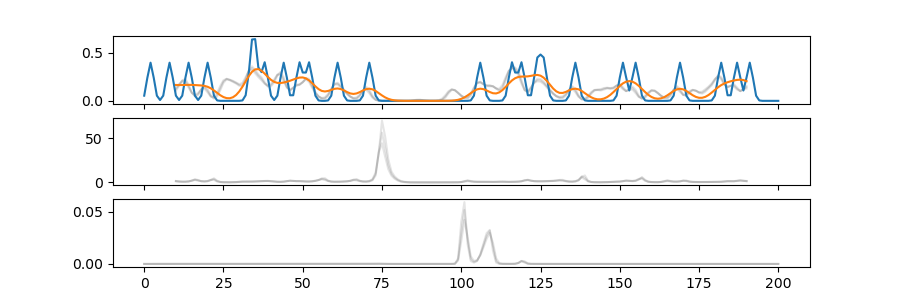

In [171]:

fig, ax = plt.subplots(3,1,sharex=True)

ker_guess = find_kernel_on_grid(grid, y_no_conv, y_conv, pad_idx=10, iterations=8,
                    ax=ax, filter_epsilon=1e-8, c_kwargs={'length':81, 'norm':True, 'integrate':False})

fig, ax = plt.subplots(3,1,sharex=True)
ker_guess = find_kernel_on_grid(grid, y_no_conv, y_conv, ker_guess=ker_guess, pad_idx=10, iterations=3,
                    ax=ax, filter_epsilon=1e-8, c_kwargs={'length':81, 'norm':True, 'integrate':False})

In [633]:
get_c_matrix(ker_inv, grid_conv, i_bounds=[1,-1])

<197x199 sparse matrix of type '<class 'numpy.float64'>'
	with 14397 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>


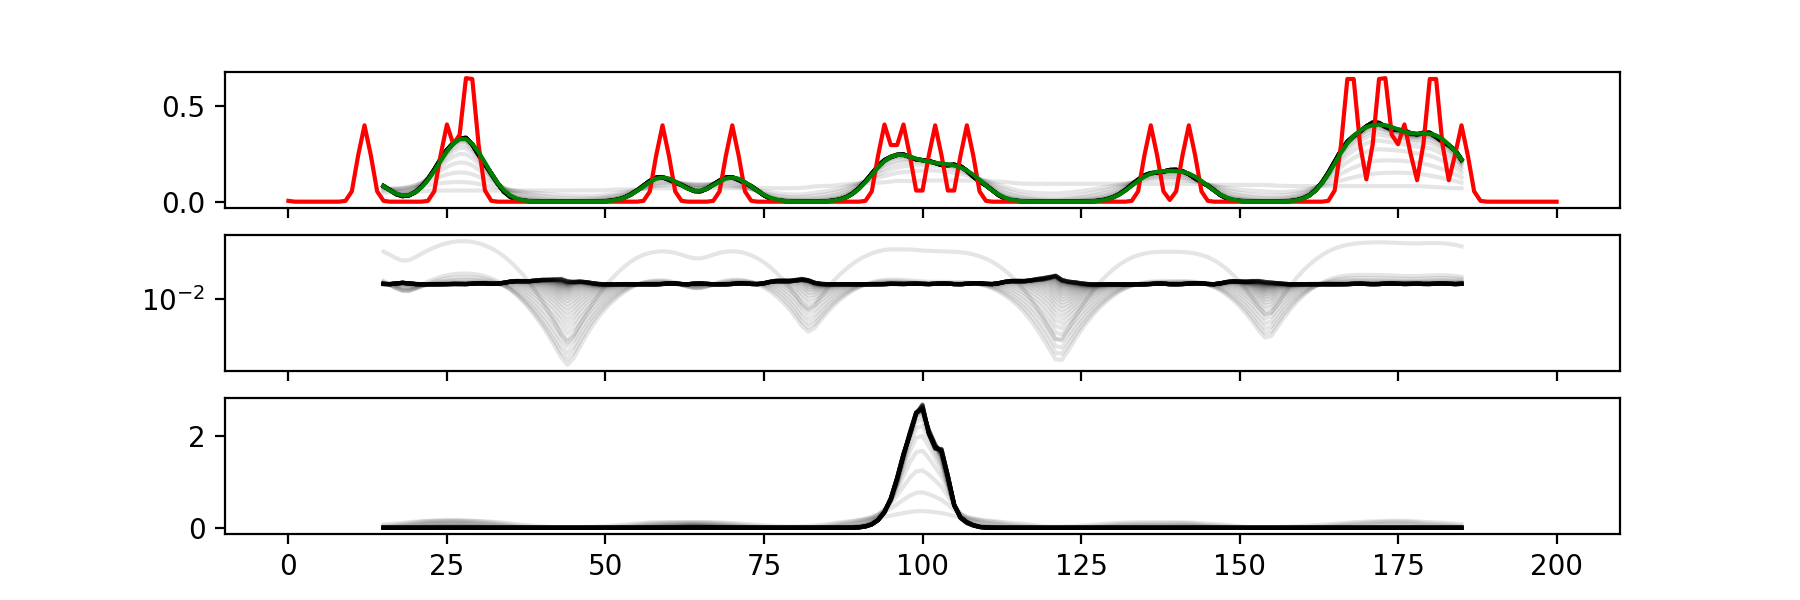

In [401]:
window = 201
ker_guess = gaussians(np.arange(201), 100, 30)

# for i_ker in range(0, 1000, 10):
i_ker = 10
y_no_conv = test_flux[1][i_ker:i_ker+window]
y_conv = test_flux[0][i_ker:i_ker+window]

fig, ax = plt.subplots(3,1,sharex=True)

_= richardson_lucy_inv(y_conv, y_no_conv, iterations=50, pad=15, ker_pad=15, ax=ax, filter_epsilon=1e-5)

# fig, ax = plt.subplots(3,1,sharex=True)
# _= richardson_lucy_inv(y_conv, y_no_conv, guess=_, iterations=5, pad=1, ker_pad=1, ax=ax, filter_epsilon=1e-5)

# fig, ax = plt.subplots(3,1,sharex=True)
# _= richardson_lucy_inv(y_conv, y_no_conv, guess=_, iterations=10, pad=1, ker_pad=1, ax=ax, filter_epsilon=1e-5)

<IPython.core.display.Javascript object>


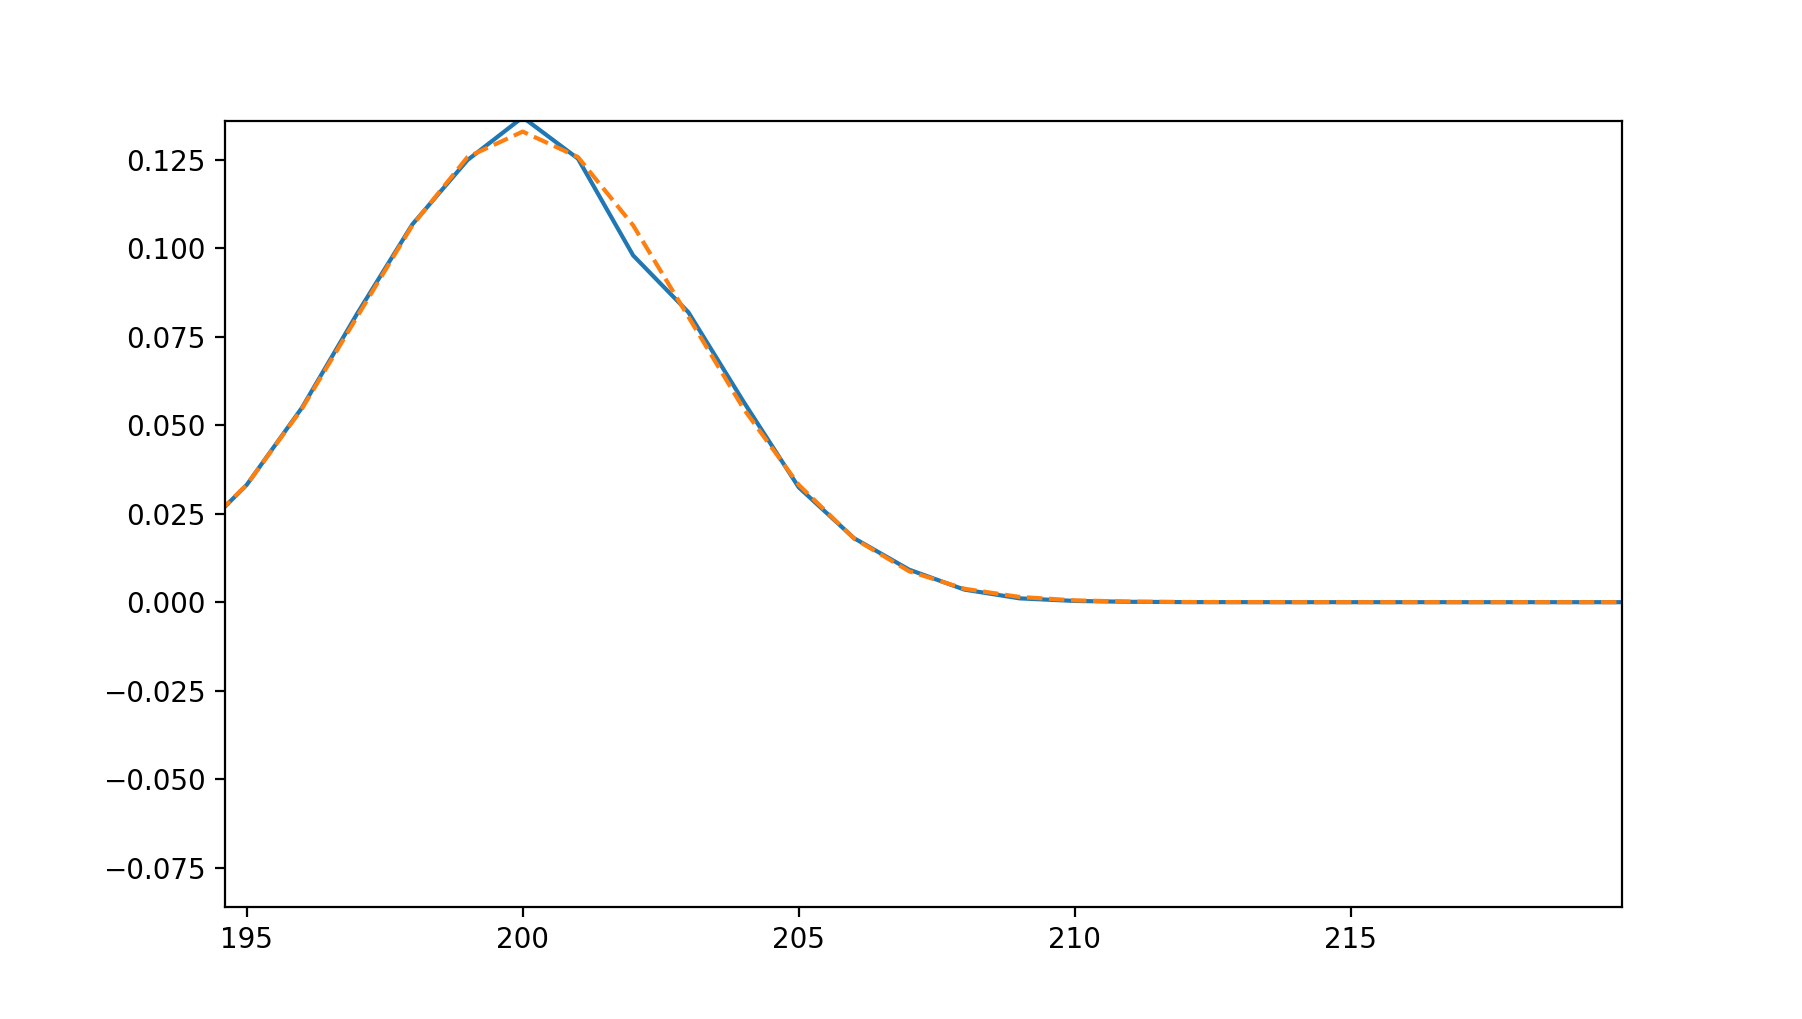

In [397]:
plt.figure()
plt.plot(_/np.sum(_))
real_kernel = gaussians(np.arange(len(_)), len(_)//2, 3)
plt.plot(real_kernel/real_kernel.sum(), "--")

<IPython.core.display.Javascript object>


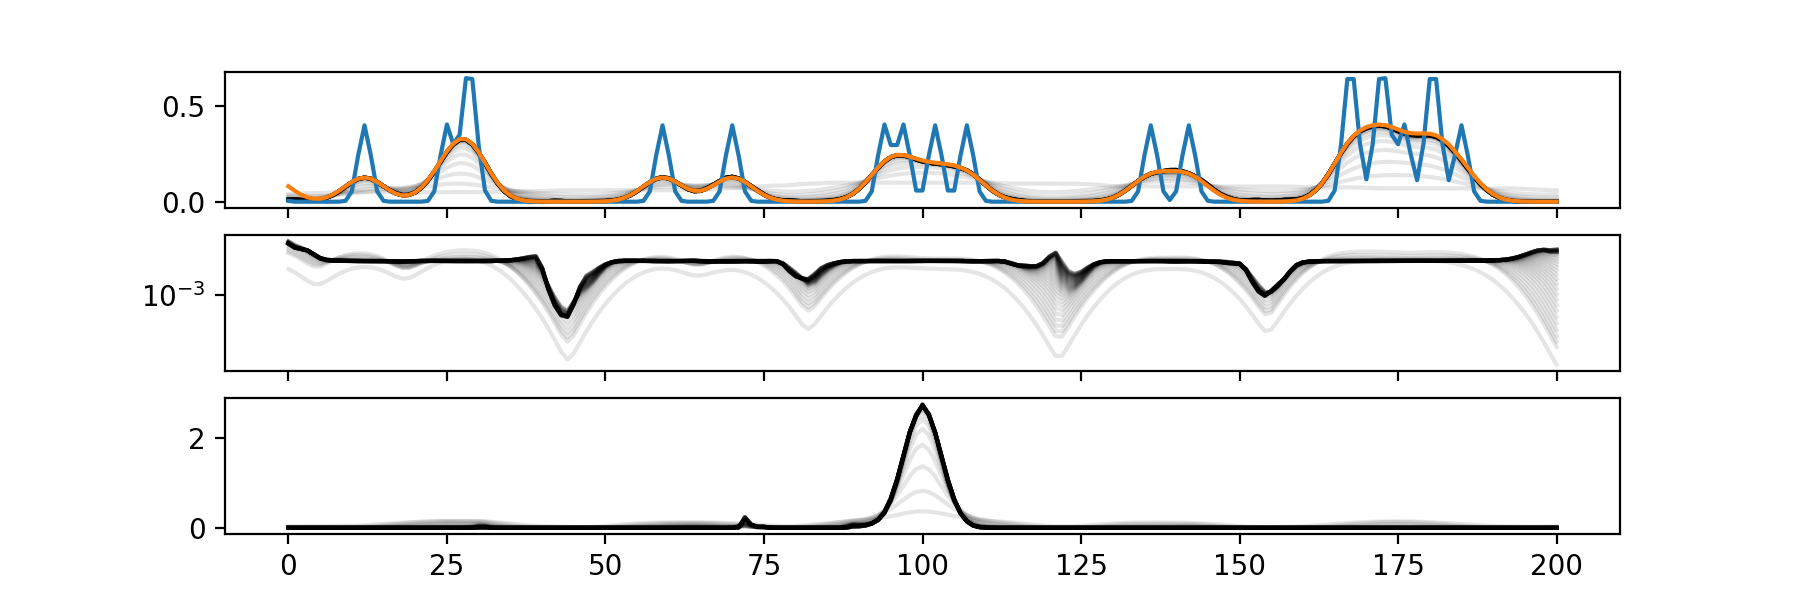

In [400]:
window = 201
ker_guess = gaussians(np.arange(201), 100, 30)

# for i_ker in range(0, 1000, 10):
i_ker = 10
y_no_conv = test_flux[1][i_ker:i_ker+window]
y_conv = test_flux[0][i_ker:i_ker+window]

fig, ax = plt.subplots(3,1,sharex=True)

_= richardson_lucy_classic(y_conv, y_no_conv, iterations=50, filter_epsilon=1e-5, ax=ax)

# ax[0].plot(np.convolve(y_no_conv, _/_.sum(), mode='same'))
# ax[0].plot(y_conv)
# ax[0].plot(y_no_conv)

# ax[1].plot(_)

<IPython.core.display.Javascript object>


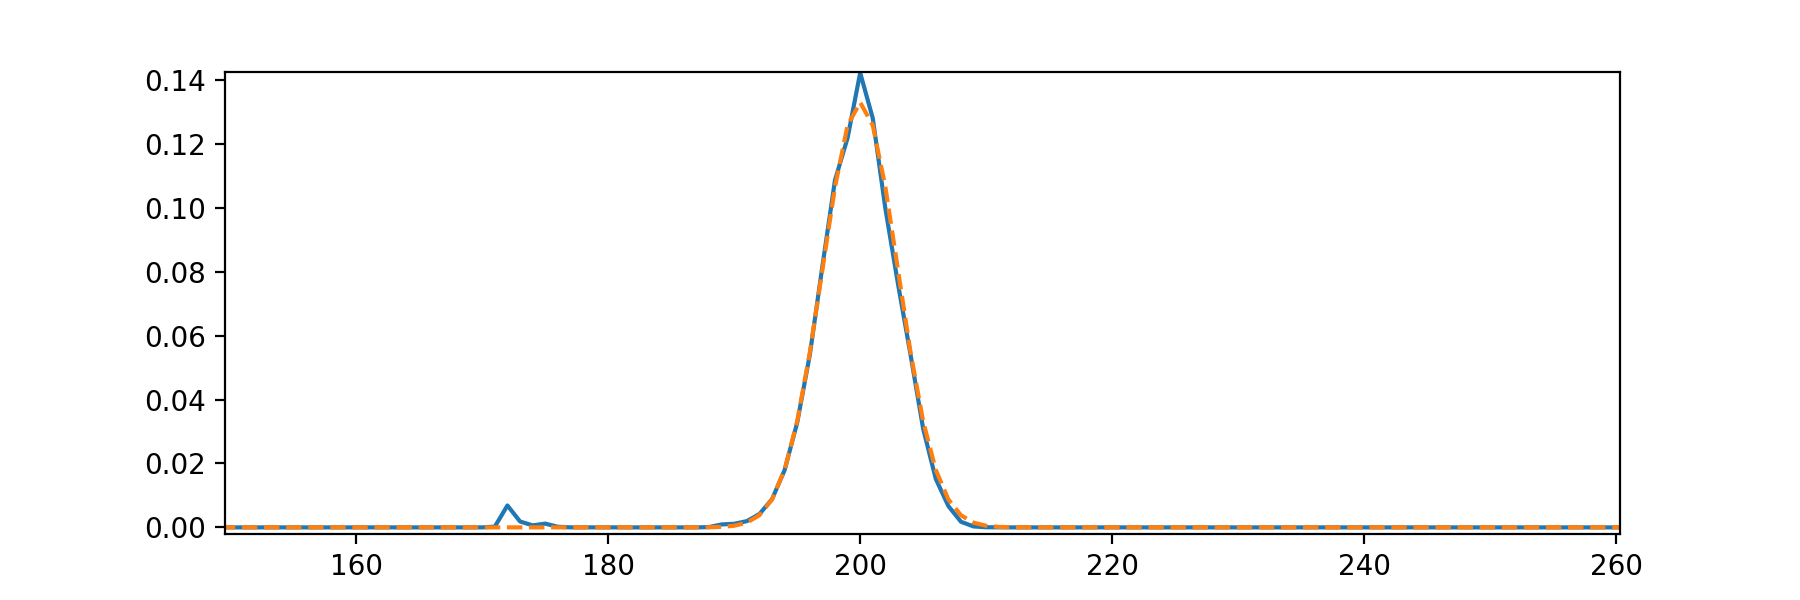

In [399]:
plt.figure()
plt.plot(_/np.sum(_))
real_kernel = gaussians(np.arange(len(_)), len(_)//2, 3)
plt.plot(real_kernel/real_kernel.sum(), "--")

<IPython.core.display.Javascript object>


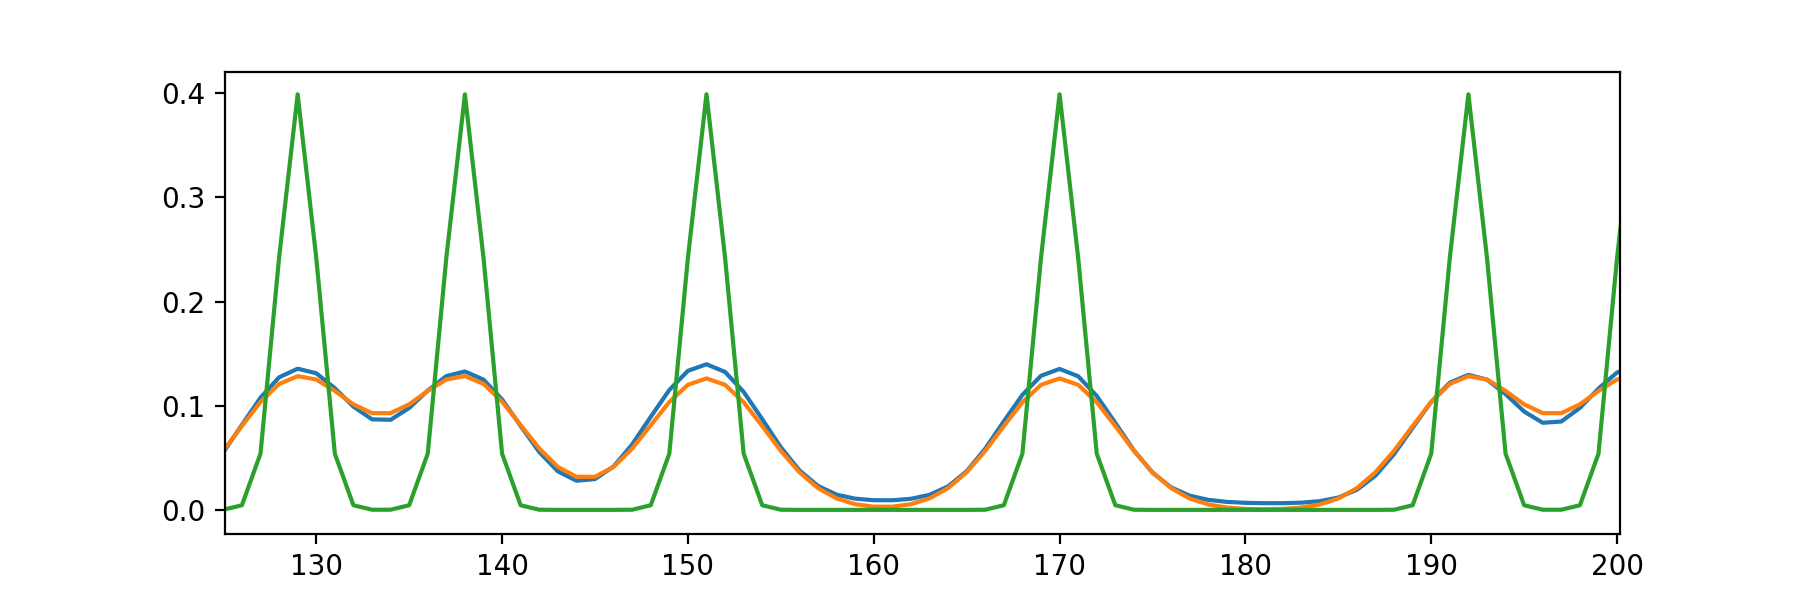

In [348]:
plt.figure()
plt.plot(np.convolve(y_no_conv, _/_.sum(), mode='same'))
plt.plot(y_conv)
plt.plot(y_no_conv)

In [111]:
def richardson_lucy(x_conv, kernel, guess=None, iterations=50, pad=20, ax=None):

    if guess is None:
        guess = np.full(x_conv.shape, 0.5, dtype=float)
    
    x_deconv = guess.copy()
    
    x_deconv[:pad] = np.nan
    x_deconv[-pad:] = np.nan
        
    kernel_mirror = np.flip(kernel)

    for _ in range(iterations):
        conv = convolve(x_deconv, kernel, boundary='extend', preserve_nan=True)
        relative_blur = x_conv / conv
        x_deconv *= convolve(relative_blur, kernel_mirror, boundary='extend', preserve_nan=False)
        if ax is not None:
            ax.plot(conv)
            ax.plot(x_deconv)

    return x_deconv

def trim_box(x_deconv, x_conv, kernel, box_h_len=None, ker_quantile_kwargs=None):
    
    # Use kernel quantile to define box half length
    if box_h_len is None:
        # Explicitely specify default quantile
        if ker_quantile_kwargs is None:
            ker_quantile_kwargs = {'quantile': 0.99}
        box_h_len = kernel_quantile_length(kernel, **ker_quantile_kwargs)
        # Make sure it is integer
        box_h_len = np.ceil(box_h_len).astype(int)
        
    # Box mask
    big_box = np.ones_like(x_deconv)
    big_box[:box_h_len] = 0
    big_box[-box_h_len:] = 0
        
    # Box trim the input not convolved
    big_box = np.convolve(big_box, kernel, mode='same')
    x_deconv_box = x_deconv * big_box

    # Replace the values in the convolved input
    # by the convolved box trimmed input
    conv_box = np.convolve(big_box, kernel, mode='same')
    x_conv_box = x_conv * conv_box
    
    return x_deconv_box, x_conv_box

def kernel_quantile_length(kernel, quantile=0.95, x_kernel=None, center_ker=None, spl_kwargs=None):
    
    # Default kwargs for univariate spline
    if spl_kwargs is None:
        # No smoothing
        spl_kwargs = {'s': 0}
    
    # Length of the kernel array
    ker_len = len(kernel)
    
    # If kernel position not given, assume it is centered
    # and equally spaced
    if x_kernel is None:
        x_kernel = np.linspace(-ker_len/2, ker_len/2, ker_len)
        
    # Find kernel center (with center of mass)
    if center_ker is None:
        ker_center = np.sum(x_kernel * kernel) / np.sum(kernel)
        # Re-center x_kernel
        x_kernel = x_kernel - ker_center
       
    # Spline kernel
    ker_spl = UnivariateSpline(x_kernel, kernel, **spl_kwargs)
    
    # Compute quantile as a function of the distance from kernel center
    # Use all nodes from np.abs(x_kernel)
    half_len = np.unique(np.abs(x_kernel))
    # Make sure it does not extrapolate, so take the minimum
    # absolute value at the extremities.
    max_half_len = np.min(np.abs(x_kernel)[[0, -1]])
    half_len = half_len[half_len <= max_half_len]
    # Compute integral
    quant = []
    for idx in range(len(half_len)):
        grid = [-1*half_len[1:idx], half_len[:idx]]
        grid = np.concatenate(grid)
        grid = np.unique(grid)
        y_grid = ker_spl(grid)
        y_grid = np.clip(grid, 0, None)
        quant.append(np.trapz(y_grid, x=grid))
#     quant = [quad(ker_spl, -h_len, h_len) for h_len in half_len]
    # Unpack (includes integration error)
    quant = np.array(quant).T
    
    # Normalize so that the integral over the full range of x_kernel
    # is equal to 1
    norm = np.trapz(kernel, x=x_kernel)
    quant = np.array(quant) / norm
    
    # Spline the quantiles - (quantile desired value)
    quant_spl = UnivariateSpline(half_len, (quant - quantile), s=0, k=1)
    
    # Find root
    # First, narrow the range for root finding
    idx_root = np.max(np.where(quant < quantile)[0])
    h_len_range = half_len[[idx_root, idx_root + 1]]
    # Find root
    out = root_scalar(quant_spl, bracket=list(h_len_range)).root
    
    return out

In [13]:
result = richardson_lucy(*trim_box(*flux, gauss_ker))

In [65]:
def envelope_conv(x_deconv, x_conv, kernel, envelope, pad, ker_quantile_kwargs=None):
    
    # Use kernel quantile to define box half length
    if pad is None:
        # Explicitely specify default quantile
        if ker_quantile_kwargs is None:
            ker_quantile_kwargs = {'quantile': 0.99}
        pad = kernel_quantile_length(kernel, **ker_quantile_kwargs)
        # Make sure it is integer
        pad = np.ceil(pad).astype(int)
        
    # Define the window function from pads
    window = np.ones_like(x_deconv)
    window[:pad] = 0
    window[-pad:] = 0
    
    # Apply window on the non convolved input
    x_deconv = x_deconv * window
        
    # Convolve the window function with the kernel estimate
    window_conv = np.convolve(window, kernel, mode='same')
    # Estimate the effect of the window on the convolved input
    x_conv_trim = np.convolve(x_deconv, kernel, mode='same')
    # Take a weighted mean of the input and the trimmed version
    x_conv = x_conv * window_conv + x_conv_trim * (1 - window_conv)

    
    # Apply envelope convolution
    x_deconv = np.convolve(x_deconv, envelope, mode='same')
    x_conv = np.convolve(x_conv, envelope, mode='same')
    
    return x_deconv, x_conv
    

In [85]:
envelope = gaussians(np.arange(201), 100, 15)

In [282]:
test_flux_in = (np.random.rand(len(flux[0])) > 0.9).astype(float)

test_flux = []
test_flux.append(np.convolve(test_flux_in, gaussians(np.arange(101), 50, 4), mode='same'))
test_flux.append(np.convolve(test_flux_in, gaussians(np.arange(101), 50, 1), mode='same'))

In [1]:
window = 801
n_guess_init = 1
ker_guess = gauss_ker
kernel_list = []
first_loop = True

# for i_ker in range(0, 1000, 10):
i_ker = 10
# y_no_conv = flux[1][i_ker:i_ker+window]
# y_conv = flux[0][i_ker:i_ker+window]
y_no_conv = test_flux[1][i_ker:i_ker+window]
y_conv = test_flux[0][i_ker:i_ker+window]

if first_loop:
    n_guess = n_guess_init
    first_loop = False
else:
    n_guess = 1

fig, ax = plt.subplots(2, 1)
for i_guess in range(n_guess):
    print(f"i_ker:{i_ker}, i_guess:{i_guess}", end='\r')
#     y_trim, y_conv_trim = envelope_conv(y_no_conv, y_conv, ker_guess, envelope, 10)
    y_trim, y_conv_trim = y_no_conv.copy(), y_conv.copy()
    try:
        ker_guess = richardson_lucy_inv(y_conv_trim, y_trim, iterations=2, guess=ker_guess, ax=ax[1])
    except:
        ker_guess = richardson_lucy_inv(y_conv_trim, y_trim, iterations=2, ax=ax[1])
    ker_guess /= ker_guess.sum()
    ax[0].plot(ker_guess, "k", alpha=0.1)
#     ax[1].plot(y_conv_trim, "k", alpha=0.1)
    
# plt.figure()
# for i_guess in range(n_guess):
#     print(f"i_ker:{i_ker}, i_guess:{i_guess}", end='\r')
# #     y_trim, y_conv_trim = envelope_conv(y_no_conv, y_conv, ker_guess, envelope, 10)
#     y_trim, y_conv_trim = y_no_conv.copy(), y_conv.copy()
#     ker_guess = richardson_lucy(y_conv_trim, y_trim, iterations=50, guess=ker_guess)
#     ker_guess /= ker_guess.sum()
#     plt.plot(ker_guess, "k", alpha=0.1)

kernel_list.append(ker_guess)



kernel_list = np.array(kernel_list)

plt.figure()
# plt.plot(y_no_conv)
# plt.plot(np.convolve(y_no_conv, kernel_list[0], mode='same'))
# plt.plot(y_conv)

plt.plot(y_trim)
plt.plot(y_conv_trim)
plt.plot(np.convolve(y_trim, kernel_list[0], mode='same'),"--")

NameError: name 'gauss_ker' is not defined

In [197]:
kernel_list.shape

(301, 1)

<IPython.core.display.Javascript object>


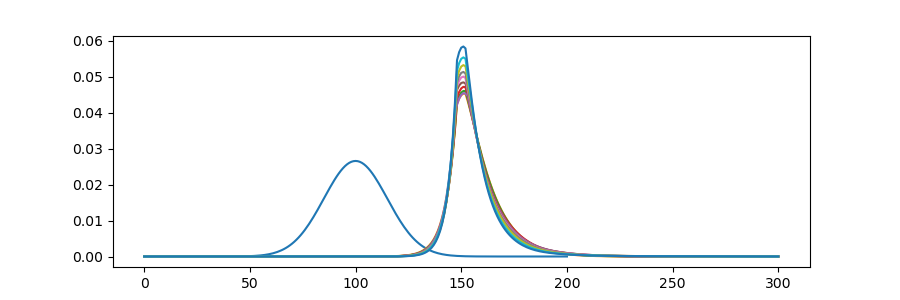

In [237]:
plt.plot(gauss_ker)
plt.plot(kernel_list[:, :10])

<IPython.core.display.Javascript object>


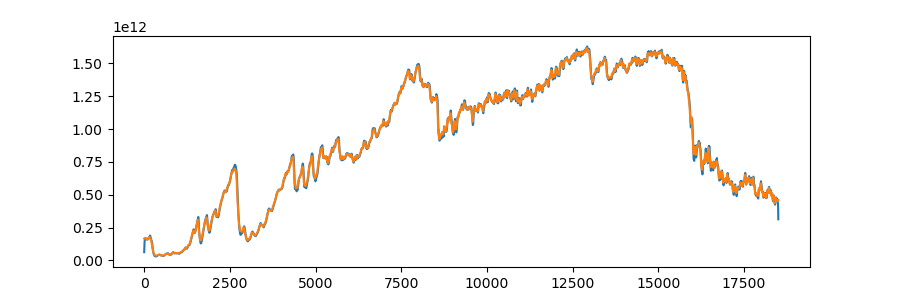

In [238]:
plt.plot(np.convolve(flux[1], kernel_list[:,10], mode='same'))
plt.plot(flux[0])

### Tikhonov 

In [45]:
def find_const_conv_kernel(y, y_conv, length):
    
    y_conv_len = len(y) - length
    half_len = length // 2
    y_matrix = np.array([y[idx:idx+length] for idx in range(y_conv_len)])
    return y_matrix

In [46]:
y_matrix=find_const_conv_kernel(flux[1][:1000], flux[0][:1000], 201)

<IPython.core.display.Javascript object>


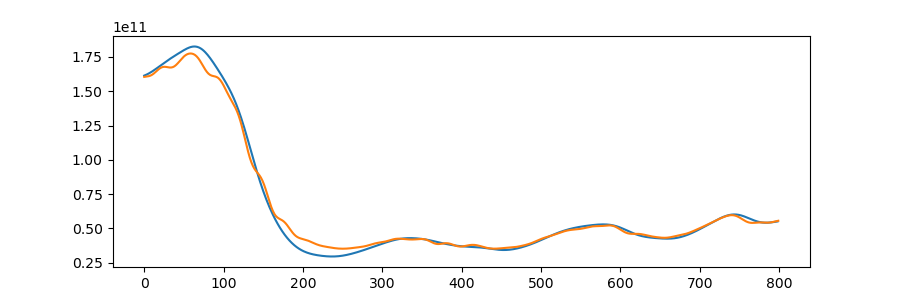

In [47]:
plt.plot(y_matrix.dot(gauss_ker))
plt.plot(flux[0][100:900])

In [13]:
from extract.regularisation import Tikhonov

In [14]:
from extract.regularisation import finite_second_d, finite_first_d

In [48]:
# t_mat = finite_second_d(extract.lam_grid)
t_mat = finite_first_d(np.arange(201)).todense()

tikho_factor_scale = np.power(gauss_ker, -2)
tikho_factor_scale /= np.sum(tikho_factor_scale)

t_mat = np.diag(tikho_factor_scale[1:]).dot(t_mat)

In [49]:
y_matrix.dot(y_matrix.T).shape, flux[0][101:900].shape

((799, 799), (799,))

In [58]:
tikho = Tikhonov(y_matrix, flux[0][101:900], t_mat=t_mat)

In [63]:
test_tikho = tikho.test_factors(np.logspace(-20, 40, 30))

Testing factors...


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


30/30


In [64]:
test_tikho

{'factors': array([1.00000000e-20, 1.17210230e-18, 1.37382380e-16, 1.61026203e-14,
        1.88739182e-12, 2.21221629e-10, 2.59294380e-08, 3.03919538e-06,
        3.56224789e-04, 4.17531894e-02, 4.89390092e+00, 5.73615251e+02,
        6.72335754e+04, 7.88046282e+06, 9.23670857e+08, 1.08263673e+11,
        1.26896100e+13, 1.48735211e+15, 1.74332882e+17, 2.04335972e+19,
        2.39502662e+21, 2.80721620e+23, 3.29034456e+25, 3.85662042e+27,
        4.52035366e+29, 5.29831691e+31, 6.21016942e+33, 7.27895384e+35,
        8.53167852e+37, 1.00000000e+40]),
 'solution': array([[ 1.32745566e+02, -5.33858268e+02,  7.05509802e+02, ...,
          1.61540863e+03, -1.13767188e+03,  2.70195071e+02],
        [ 1.32745566e+02, -5.33858268e+02,  7.05509802e+02, ...,
          1.61540863e+03, -1.13767188e+03,  2.70195071e+02],
        [ 1.32745566e+02, -5.33858268e+02,  7.05509802e+02, ...,
          1.61540863e+03, -1.13767188e+03,  2.70195071e+02],
        ...,
        [-4.64553729e-28, -4.64553729e-2

<IPython.core.display.Javascript object>


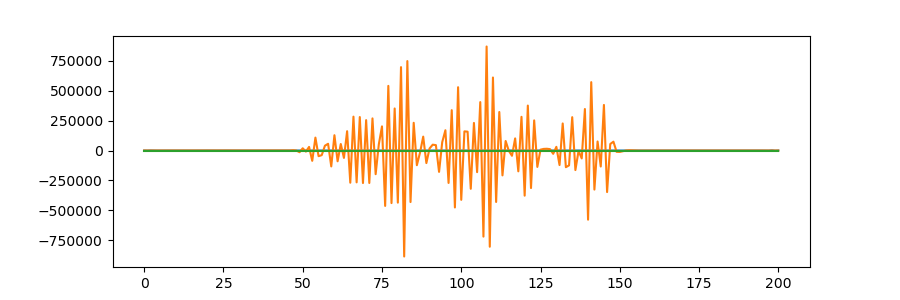

In [67]:

plt.plot(test_tikho['solution'][0])

plt.plot(test_tikho['solution'][-10])

plt.plot(test_tikho['solution'][-2])

<IPython.core.display.Javascript object>


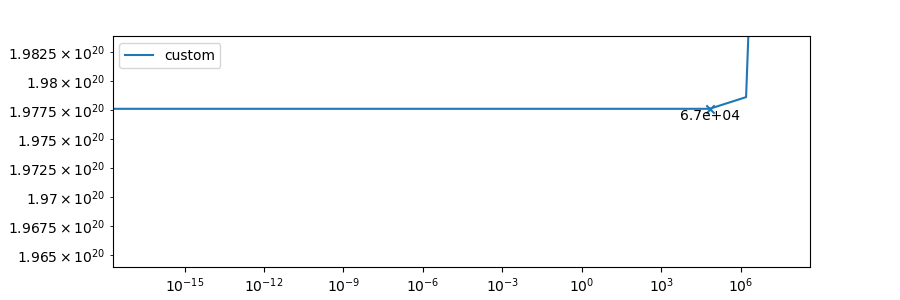

(<Figure size 900x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3813b7d10>)

In [55]:
tikho.error_plot(test=test_tikho)

<IPython.core.display.Javascript object>


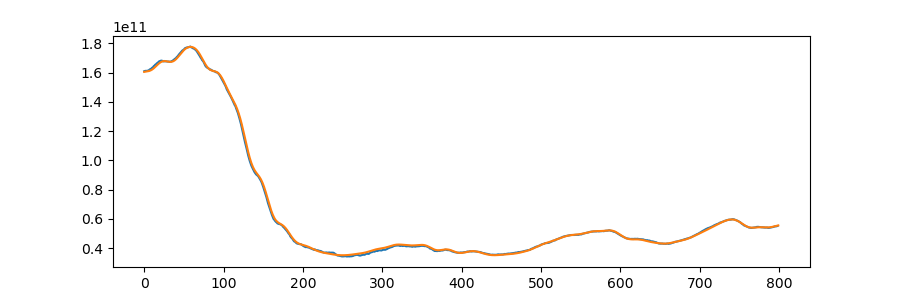

In [57]:
plt.plot(y_matrix.dot(test_tikho['solution'][0]))
plt.plot(flux[0][100:900])

<IPython.core.display.Javascript object>


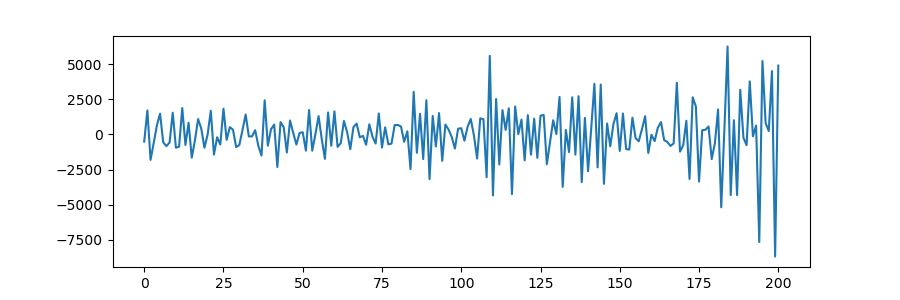

In [32]:
plt.plot(np.linalg.solve(y_matrix, simu['f_c1'][100:301]))
# plt.plot(simu['f_c2'][:20])